# Import Libraries

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

In [89]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.datasets import CIFAR10
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from torchvision import models
from torchsummary import summary
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import time as time

write code to get device

In [90]:
device = torch.device("mps")
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [91]:
accuracy_dict = {}

In [92]:
batch_size = 32

Experiments - check if change in transformation can lead to better accuracy (from medium article)

In [93]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# train_data_count = int(len(trainset) * 0.8)
# val_data_count = len(trainset) - train_data_count

# train_data, val_data = random_split(trainset,
#                                     [train_data_count, val_data_count], generator=torch.Generator().manual_seed(42))

# trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#                                           shuffle=True)

# valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
#                                           shuffle=True)

test_data = CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [94]:
# train_count = int(len(trainset*0.8))
# val_count = len(trainset)-train_count

# train_data_count = int(len(trainset) * 0.8)
# val_data_count = len(trainset) - train_data_count

# train_data, val_data = random_split(trainset,
#                                     [train_data_count, val_data_count], generator=torch.Generator().manual_seed(42))

train_indices, val_indices = train_test_split(list(range(len(trainset.targets))), test_size = 0.2, stratify = trainset.targets)

train_data = torch.utils.data.Subset(trainset, train_indices)
val_data = torch.utils.data.Subset(trainset, val_indices)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=True)


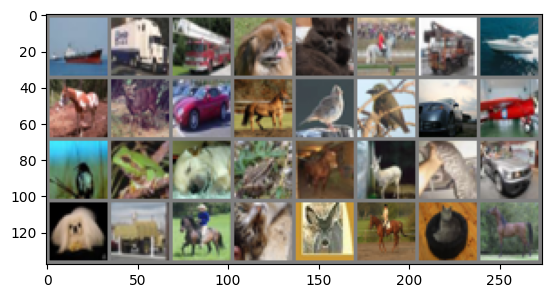

 ship truck truck   dog


In [95]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [96]:
def activation_func(act_val):
    if act_val == "ReLU":
        actfn = nn.ReLU()
    else:
        actfn = nn.ReLU()

    return actfn

In [97]:
actfn = activation_func("ReLU")

In [98]:
# Model creation
num_of_channels = 3

def baseline(padding=0):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 128, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 4 * 4 , 10),
        nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss
    

In [99]:
# baseline_model = nn.Sequential(
#     nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding = 0),
#     actfn,
#     nn.MaxPool2d(kernel_size=2, stride=1),

#     nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = 0),
#     actfn,
#     nn.MaxPool2d(kernel_size=2, stride=2),

#     nn.Conv2d(64, 128, kernel_size=2, stride=1, padding = 0),
#     actfn,
#     nn.MaxPool2d(kernel_size=2, stride=2),

#     # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = 0),
#     # actfn,
#     # nn.MaxPool2d(kernel_size=2, stride=2),
    
#     nn.Conv2d(128, 32, kernel_size=3, stride=1, padding = 0),
#     actfn,
#     nn.Flatten(),
#     nn.Linear(32 * 4 * 4 , 10),
#     nn.Softmax(1)
# ).to(device)

# classification_loss = nn.CrossEntropyLoss()

# Summary of the model

In [100]:
trial, lo= baseline()

In [101]:
summary(trial, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 30, 30]          896
├─ReLU: 1-2                              [-1, 32, 30, 30]          --
├─MaxPool2d: 1-3                         [-1, 32, 15, 15]          --
├─Conv2d: 1-4                            [-1, 128, 13, 13]         36,992
├─ReLU: 1-5                              [-1, 128, 13, 13]         --
├─MaxPool2d: 1-6                         [-1, 128, 6, 6]           --
├─Conv2d: 1-7                            [-1, 32, 4, 4]            36,896
├─ReLU: 1-8                              [-1, 32, 4, 4]            --
├─Flatten: 1-9                           [-1, 512]                 --
├─Linear: 1-10                           [-1, 10]                  5,130
├─Softmax: 1-11                          [-1, 10]                  --
Total params: 79,914
Trainable params: 79,914
Non-trainable params: 0
Total mult-adds (M): 7.60
Input size (MB): 0.01
Forward/backward pass siz

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 30, 30]          896
├─ReLU: 1-2                              [-1, 32, 30, 30]          --
├─MaxPool2d: 1-3                         [-1, 32, 15, 15]          --
├─Conv2d: 1-4                            [-1, 128, 13, 13]         36,992
├─ReLU: 1-5                              [-1, 128, 13, 13]         --
├─MaxPool2d: 1-6                         [-1, 128, 6, 6]           --
├─Conv2d: 1-7                            [-1, 32, 4, 4]            36,896
├─ReLU: 1-8                              [-1, 32, 4, 4]            --
├─Flatten: 1-9                           [-1, 512]                 --
├─Linear: 1-10                           [-1, 10]                  5,130
├─Softmax: 1-11                          [-1, 10]                  --
Total params: 79,914
Trainable params: 79,914
Non-trainable params: 0
Total mult-adds (M): 7.60
Input size (MB): 0.01
Forward/backward pass siz

In [102]:
def optimizer_func(model, optimizer_val, lr, momentum = 0):

    if optimizer_val == "SGD":
        optimizer = optim.SGD(model.parameters(), lr, momentum)
    elif optimizer_val == "Adam":
        optimizer = optim.Adam(model.parameters(), lr)
    elif optimizer_val == "NAdam":
        optimizer = optim.NAdam(model.parameters(), lr)

    return optimizer

In [103]:
# actfn = activation_func("ReLU")
# # baseline, classification_loss = baseline()
# optimizer = optimizer_func(baseline_model, "SGD")

# base_stats = {}
# train_acc_list = []
# train_loss_list = []

# for epoch in range(num_epochs):  # loop over the dataset multiple times

#     for inputs, labels in trainloader:
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = inputs.to(device), labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = baseline_model(inputs)

#         loss = loss_criterion(outputs, labels)

#         loss.backward()
        
#         optimizer.step()

        

#         loss += loss
        
#     print("ephoch trained with loss")


In [104]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return (torch.sum(preds == labels).item() / len(preds))

In [105]:
def train_model(model, classification_loss, train_loader, optimizer):

    train_loss = 0
    train_acc = 0

    model.train()

    for inputs, labels in train_loader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        loss = classification_loss(outputs, labels)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()

        train_acc += accuracy(outputs, labels)

    train_acc = train_acc/len(train_loader)

    train_loss = train_loss/len(train_loader)

    return train_acc, train_loss


In [106]:
def validate_model(model, classification_loss, val_loader, optimizer):
    
    val_loss = 0
    val_acc = 0

    model.eval()
    
    with torch.no_grad():

        for val_inputs, val_labels in val_loader:

            val_inputs, val_labels = val_inputs.to(device),val_labels.to(device)

            val_outputs = model(val_inputs)
        
            loss = classification_loss(val_outputs, val_labels)

            val_loss += loss.item()

            val_acc += accuracy(val_outputs, val_labels)

    val_acc = val_acc/len(val_loader)

    val_loss = val_loss/len(val_loader)

    return val_acc, val_loss

In [107]:
def train(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

In [108]:
# def train(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

#     actfn = activation_func(act_val)
#     model, classification_loss = baseline()
#     optimizer = optimizer_func(model, optimizer_val, lr, momentum)

#     train_acc_list = []
#     train_loss_list = []
#     train_weights_list = []
#     model_stats = []

#     for epoch in range(num_epochs):  # loop over the dataset multiple times

#         loss = 0
#         acc = 0

#         # model.train()

#         for inputs, labels in train_loader:
#             # get the inputs; data is a list of [inputs, labels]
#             inputs, labels = inputs.to(device), labels.to(device)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = model(inputs)

#             train_loss = classification_loss(outputs, labels)

#             train_loss.backward()

#             optimizer.step()

#             loss += train_loss.item()

#             acc += accuracy(outputs, labels)

#         train_acc = acc/len(trainloader)

#         loss = loss/len(trainloader)

#         val_loss = 0
#         val_acc = 0

#         # model.eval()
        
#         with torch.no_grad():

#             for val_inputs, val_labels in val_loader:

#                 val_inputs, val_labels = val_inputs.to(device),val_labels.to(device)

#                 val_outputs = model(val_inputs)
            
#                 loss = classification_loss(val_outputs, val_labels)

#                 val_loss += loss.item()

#                 val_acc += accuracy(val_outputs, val_labels)

#         val_acc = val_acc/len(valloader)

#         val_loss = val_loss/len(valloader)


#         print(f"Epoch {epoch} trained with loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

#         stats = {"Epoch": epoch, "Train_loss": loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

#         model_stats.append(stats)
        
#         # model_stats[epoch]


#     return loss.item(), train_acc

#     # def validate_model(train_loss):
        
        
        


Epoch 1 trained with training loss: 2.3016797830581663 and validation loss: 2.3004701053753447 and training accuracy 0.1009 and validation accuracy 0.09994009584664537
Epoch 2 trained with training loss: 2.2968552600860597 and validation loss: 2.290235346498581 and training accuracy 0.105425 and validation accuracy 0.1363817891373802
Epoch 3 trained with training loss: 2.260659046936035 and validation loss: 2.222054617854353 and training accuracy 0.190075 and validation accuracy 0.23632188498402557
Epoch 4 trained with training loss: 2.186404708862305 and validation loss: 2.165852297609226 and training accuracy 0.27105 and validation accuracy 0.28833865814696485
Epoch 5 trained with training loss: 2.1452293108940124 and validation loss: 2.1472541326151107 and training accuracy 0.307975 and validation accuracy 0.30581070287539935
Epoch 6 trained with training loss: 2.125785300540924 and validation loss: 2.1314813706059805 and training accuracy 0.32855 and validation accuracy 0.324880191

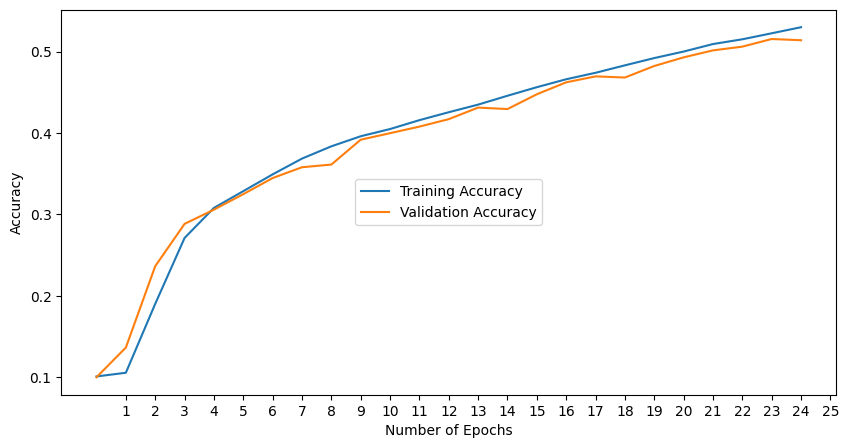

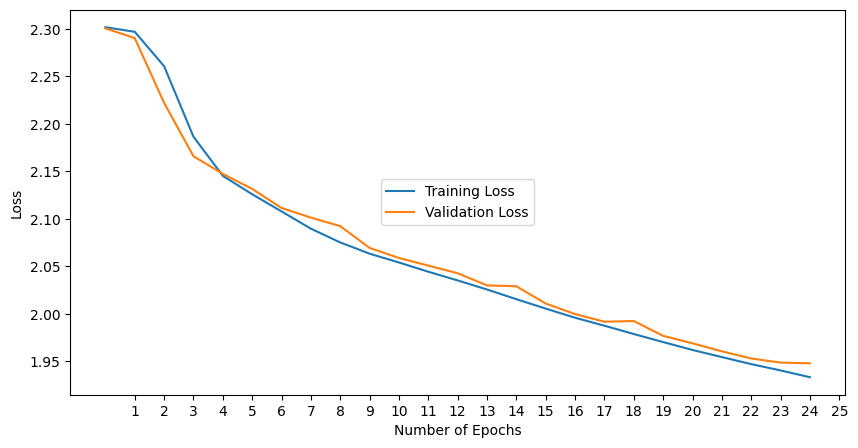

0.5139776357827476


In [109]:
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 25
lr = 0.01
momentum = 0

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict.update({"Model": ["Baseline"], "Batch Size": [batch_size], "Padding": [0], "Optimizer": [optimizer_val], "Number of epochs": [num_epochs], "Learning Rate": [lr], "Momentum": [momentum], "Run Time": [ex_time], "Validation Accuracy": [model_accuracy*100]})

print(model_accuracy)

In [110]:
print(accuracy_dict)

{'Model': ['Baseline'], 'Batch Size': [32], 'Padding': [0], 'Optimizer': ['SGD'], 'Number of epochs': [25], 'Learning Rate': [0.01], 'Momentum': [0], 'Run Time': [374.1261760000016], 'Validation Accuracy': [51.397763578274756]}


Epoch 1 trained with training loss: 2.3025460664749144 and validation loss: 2.302429338613638 and training accuracy 0.1212 and validation accuracy 0.1260982428115016
Epoch 2 trained with training loss: 2.30234317073822 and validation loss: 2.3022257261002026 and training accuracy 0.13085 and validation accuracy 0.13079073482428116
Epoch 3 trained with training loss: 2.30212360534668 and validation loss: 2.3020052117661547 and training accuracy 0.1371 and validation accuracy 0.13119009584664537
Epoch 4 trained with training loss: 2.301882202529907 and validation loss: 2.3017549872779237 and training accuracy 0.135925 and validation accuracy 0.1295926517571885
Epoch 5 trained with training loss: 2.3016100734710694 and validation loss: 2.3014749399008463 and training accuracy 0.133425 and validation accuracy 0.12889376996805113
Epoch 6 trained with training loss: 2.3012997959136965 and validation loss: 2.3011535067146958 and training accuracy 0.130625 and validation accuracy 0.12859424920

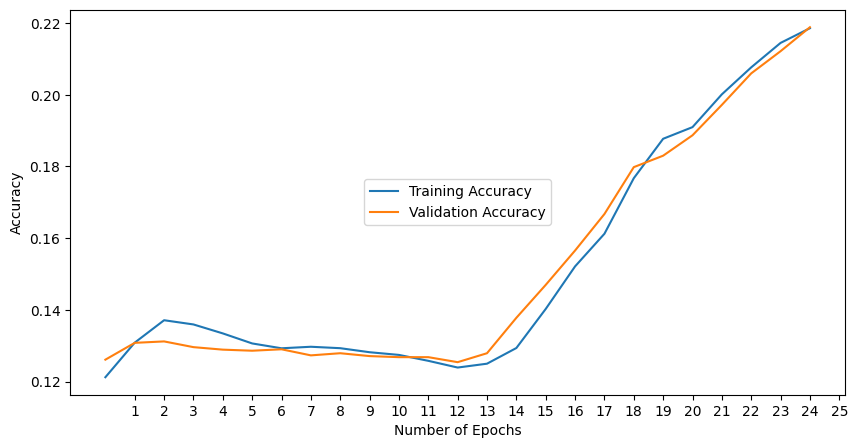

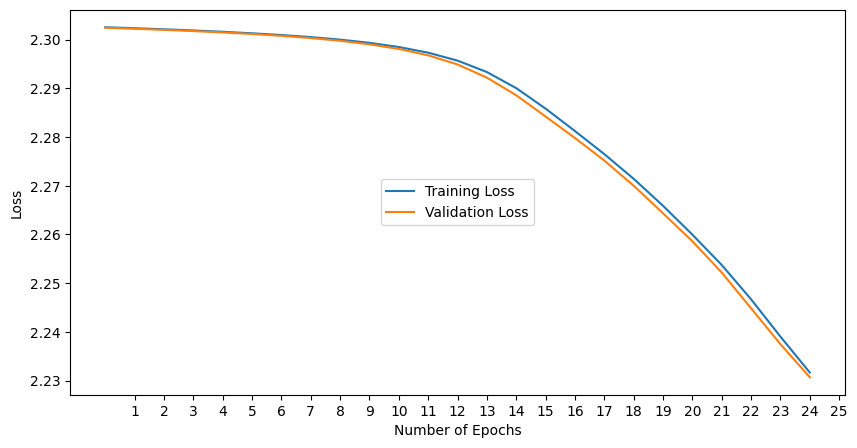

0.21884984025559107


In [111]:
padding = 0
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 25
lr = 0.001
momentum = 0


model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)
# accuracy_dict.update({"Model": ["Baseline"], "Optimizer": [optimizer_val], "Number of epochs": [num_epochs], "Learning Rate": [lr], "Momentum": [momentum], "Validation Accuracy": [model_accuracy*100]})

print(model_accuracy)

# Momentum

## different momentum values


Epoch 1 trained with training loss: 2.302000768852234 and validation loss: 2.300546148714547 and training accuracy 0.12425 and validation accuracy 0.10523162939297125
Epoch 2 trained with training loss: 2.291110356903076 and validation loss: 2.275561567312612 and training accuracy 0.110475 and validation accuracy 0.15135782747603835
Epoch 3 trained with training loss: 2.244375552749634 and validation loss: 2.2118309283028013 and training accuracy 0.209525 and validation accuracy 0.23931709265175719
Epoch 4 trained with training loss: 2.1690523732185363 and validation loss: 2.1482488777690802 and training accuracy 0.28795 and validation accuracy 0.31150159744408945
Epoch 5 trained with training loss: 2.127346210861206 and validation loss: 2.1275395794798393 and training accuracy 0.326075 and validation accuracy 0.3246805111821086
Epoch 6 trained with training loss: 2.1069121658325196 and validation loss: 2.1116434693717347 and training accuracy 0.352175 and validation accuracy 0.3418530

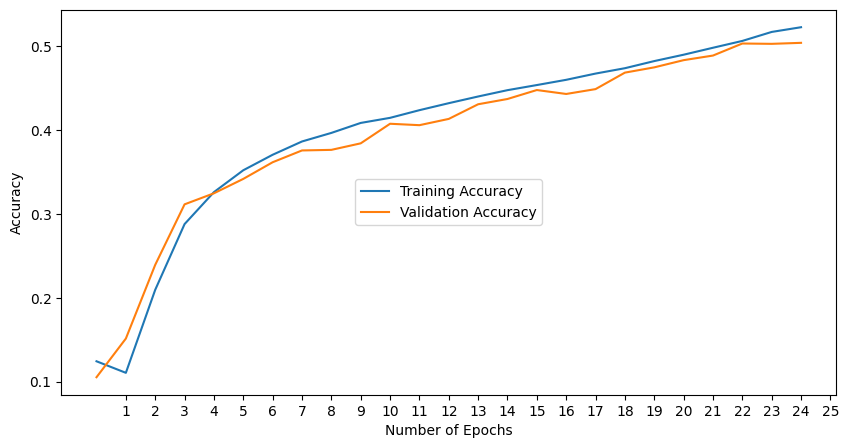

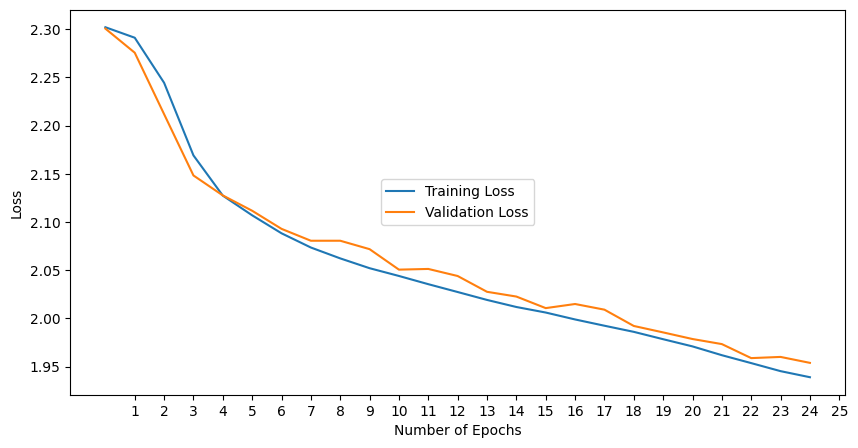

0.5041932907348243


In [112]:
padding = 0
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 25
lr = 0.01
momentum = 0.1


model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)
# accuracy_dict.update({"Model": ["Baseline"], "Optimizer": [optimizer_val], "Number of epochs": [num_epochs], "Learning Rate": [lr], "Momentum": [momentum], "Validation Accuracy": [model_accuracy*100]})

print(model_accuracy)

Epoch 1 trained with training loss: 2.302655316606353 and validation loss: 2.302602756023407 and training accuracy 0.12559335443037975 and validation accuracy 0.12248391544117647
Epoch 2 trained with training loss: 2.302489504029479 and validation loss: 2.302447032928467 and training accuracy 0.12418413765822785 and validation accuracy 0.11572840073529411
Epoch 3 trained with training loss: 2.3023360047159316 and validation loss: 2.3022696137428285 and training accuracy 0.1169649920886076 and validation accuracy 0.11100643382352941
Epoch 4 trained with training loss: 2.3021432961089703 and validation loss: 2.302079105377197 and training accuracy 0.11036392405063292 and validation accuracy 0.10689338235294117
Epoch 5 trained with training loss: 2.3019366294522827 and validation loss: 2.3018503308296205 and training accuracy 0.10628461234177215 and validation accuracy 0.105078125
Epoch 6 trained with training loss: 2.3016928147666063 and validation loss: 2.301597464084625 and training ac

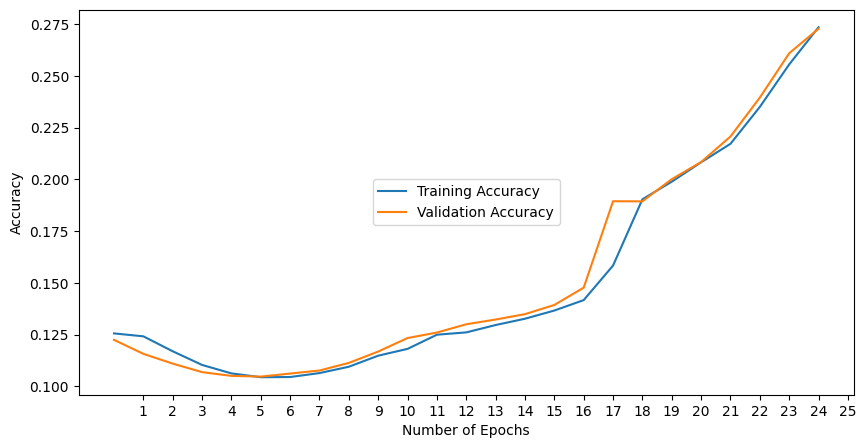

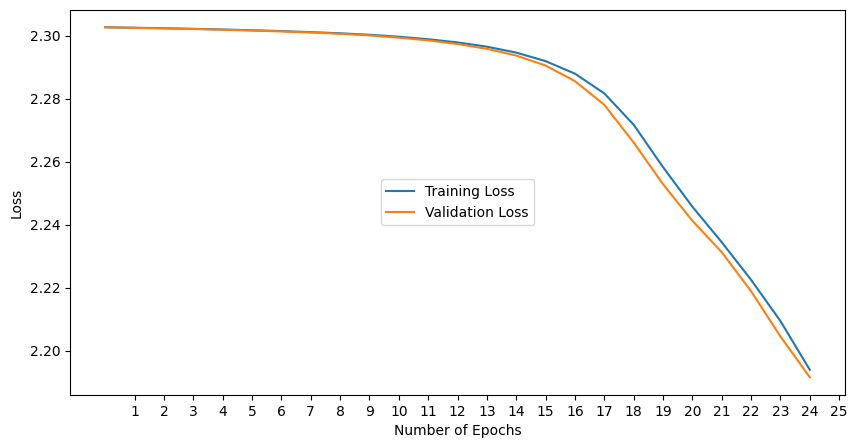

0.27279986213235297


In [144]:
padding = 0
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 25
lr = 0.01
momentum = 0.5


model_accuracy,ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)
# accuracy_dict.update({"Model": ["Baseline"], "Optimizer": [optimizer_val], "Number of epochs": [num_epochs], "Learning Rate": [lr], "Momentum": [momentum], "Validation Accuracy": [model_accuracy*100]})

print(model_accuracy)

Epoch 1 trained with training loss: 2.193235537338257 and validation loss: 2.122327894067612 and training accuracy 0.256975 and validation accuracy 0.32727635782747605
Epoch 2 trained with training loss: 2.0653159644126893 and validation loss: 2.0392854164202756 and training accuracy 0.39085 and validation accuracy 0.4188298722044728
Epoch 3 trained with training loss: 2.011844250679016 and validation loss: 2.018631324600488 and training accuracy 0.44515 and validation accuracy 0.4381988817891374
Epoch 4 trained with training loss: 1.9729642317771912 and validation loss: 1.9733855320622746 and training accuracy 0.484425 and validation accuracy 0.48312699680511184
Epoch 5 trained with training loss: 1.9376440783500672 and validation loss: 1.9292076209101814 and training accuracy 0.520875 and validation accuracy 0.5301517571884984
Epoch 6 trained with training loss: 1.9090987891197204 and validation loss: 1.927315850608265 and training accuracy 0.549025 and validation accuracy 0.53075079

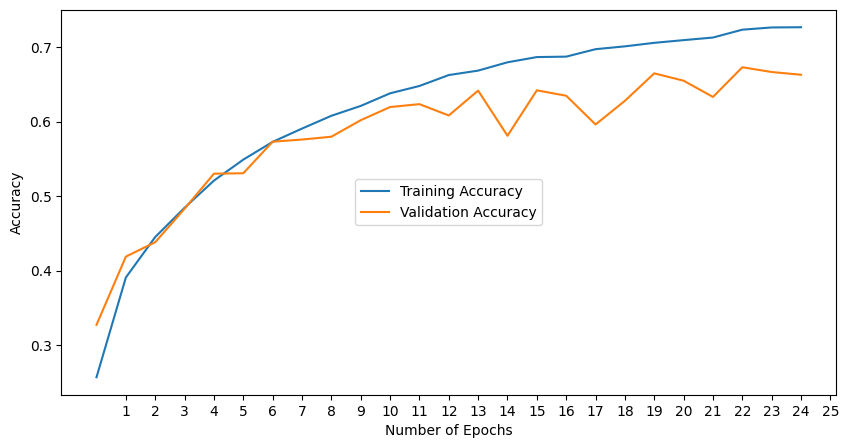

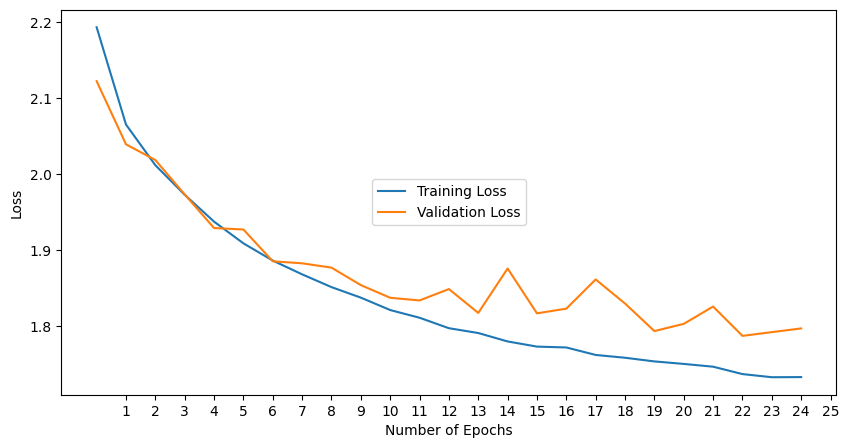

0.6629392971246006


In [114]:
padding = 0
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 25
lr = 0.01
momentum = 0.9


model_accuracy,ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)
# accuracy_dict.update({"Model": ["Baseline"], "Optimizer": [optimizer_val], "Number of epochs": [num_epochs], "Learning Rate": [lr], "Momentum": [momentum], "Validation Accuracy": [model_accuracy*100]})

print(model_accuracy)

# Learning Rate

## Adam with lr = 0.01

Epoch 1 trained with training loss: 2.288570362663269 and validation loss: 2.361210073525913 and training accuracy 0.1697 and validation accuracy 0.09994009584664537
Epoch 2 trained with training loss: 2.3611501693725585 and validation loss: 2.361110233270322 and training accuracy 0.1 and validation accuracy 0.10003993610223642
Epoch 3 trained with training loss: 2.3611501693725585 and validation loss: 2.361110233270322 and training accuracy 0.1 and validation accuracy 0.10003993610223642
Epoch 4 trained with training loss: 2.3611501693725585 and validation loss: 2.361110233270322 and training accuracy 0.1 and validation accuracy 0.10003993610223642
Epoch 5 trained with training loss: 2.3611501693725585 and validation loss: 2.361309913781504 and training accuracy 0.1 and validation accuracy 0.09984025559105432
Epoch 6 trained with training loss: 2.3611501693725585 and validation loss: 2.361110233270322 and training accuracy 0.1 and validation accuracy 0.10003993610223642
Epoch 7 traine

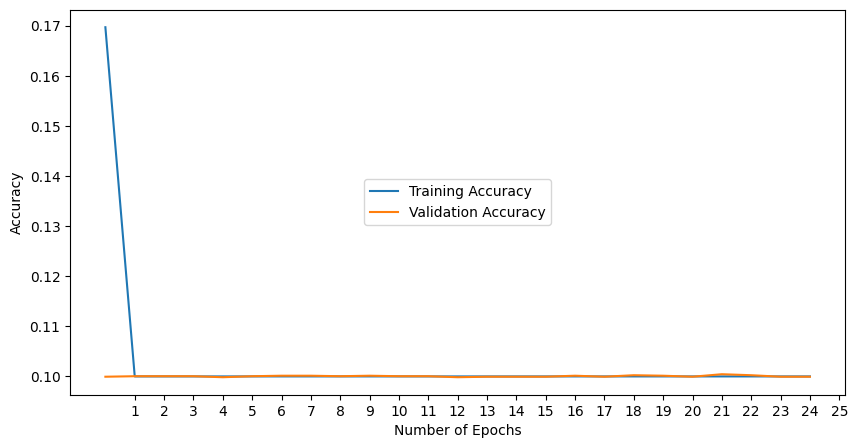

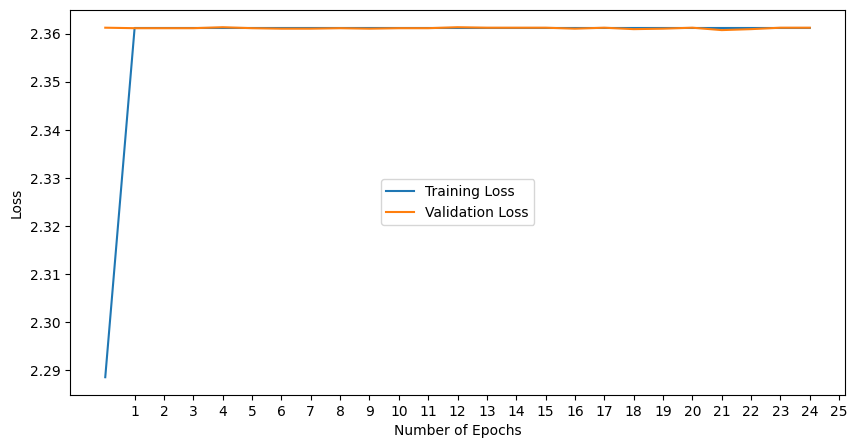

0.09994009584664537


In [115]:
padding = 0
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.01
momentum = "N.A."


model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)
# accuracy_dict.update({"Model": ["Baseline"], "Optimizer": [optimizer_val], "Number of epochs": [num_epochs], "Learning Rate": [lr], "Momentum": [momentum], "Validation Accuracy": [model_accuracy*100]})

print(model_accuracy)

## Adam with lr = 0.001

Epoch 1 trained with training loss: 2.101371538734436 and validation loss: 2.0314188510084303 and training accuracy 0.35245 and validation accuracy 0.4245207667731629
Epoch 2 trained with training loss: 1.9887235558509826 and validation loss: 1.9685543379463708 and training accuracy 0.4677 and validation accuracy 0.48682108626198084
Epoch 3 trained with training loss: 1.9373811940193175 and validation loss: 1.9272060344775264 and training accuracy 0.52045 and validation accuracy 0.5315495207667732
Epoch 4 trained with training loss: 1.9065174466133117 and validation loss: 1.9055688830610282 and training accuracy 0.551375 and validation accuracy 0.5536142172523961
Epoch 5 trained with training loss: 1.8828073372840881 and validation loss: 1.879608993332226 and training accuracy 0.575175 and validation accuracy 0.5787739616613419
Epoch 6 trained with training loss: 1.8632750117301942 and validation loss: 1.874650210618211 and training accuracy 0.596875 and validation accuracy 0.583666134

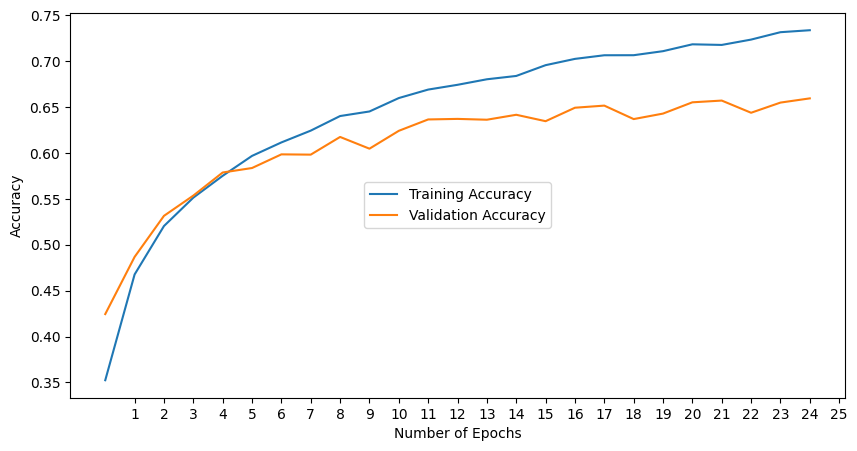

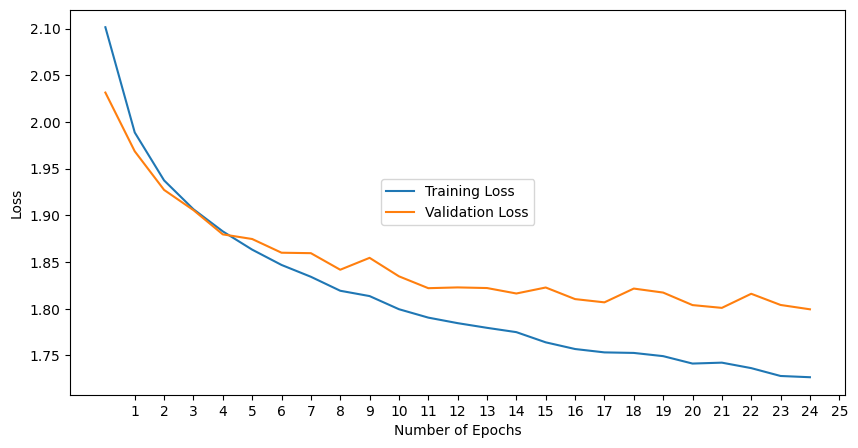

In [116]:
padding = 0
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = "N.A."

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

## NAdam with lr = 0.001

Epoch 1 trained with training loss: 2.073285550403595 and validation loss: 2.0118906105669163 and training accuracy 0.37965 and validation accuracy 0.4457867412140575
Epoch 2 trained with training loss: 1.965550640106201 and validation loss: 1.958736918604793 and training accuracy 0.490675 and validation accuracy 0.5006988817891374
Epoch 3 trained with training loss: 1.9222495358467102 and validation loss: 1.9236920904427672 and training accuracy 0.535875 and validation accuracy 0.5341453674121406
Epoch 4 trained with training loss: 1.888725973701477 and validation loss: 1.9027928483371916 and training accuracy 0.570325 and validation accuracy 0.556908945686901
Epoch 5 trained with training loss: 1.8621368898391724 and validation loss: 1.868406247787963 and training accuracy 0.597425 and validation accuracy 0.5921525559105432
Epoch 6 trained with training loss: 1.8462839417457582 and validation loss: 1.8671464878149306 and training accuracy 0.6133 and validation accuracy 0.589956070287

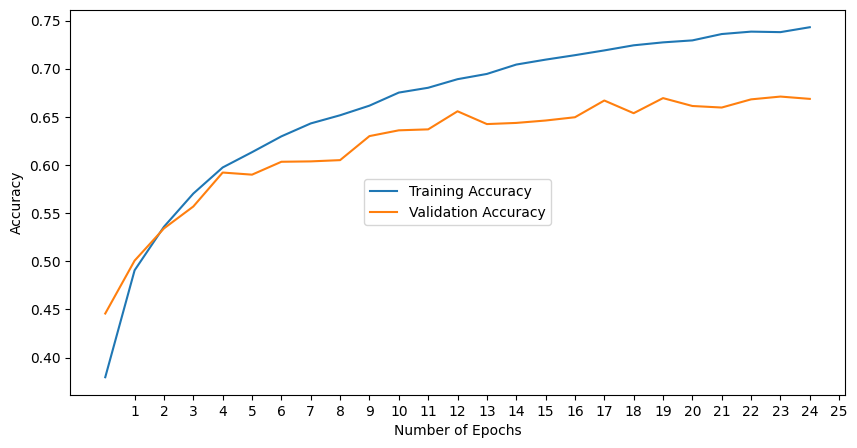

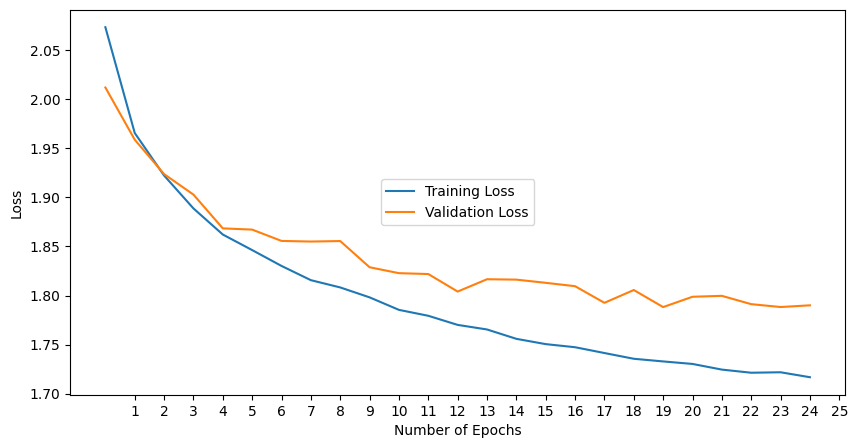

In [117]:
padding = 0
act_val = "ReLU"
optimizer_val = "NAdam"
num_epochs = 25
lr = 0.001
momentum = "N.A."

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

## Adam with lr 0.0001

Epoch 1 trained with training loss: 2.153246202373505 and validation loss: 2.110249208566099 and training accuracy 0.30325 and validation accuracy 0.3422523961661342
Epoch 2 trained with training loss: 2.074147431755066 and validation loss: 2.079681110077392 and training accuracy 0.3841 and validation accuracy 0.3791932907348243
Epoch 3 trained with training loss: 2.046242146873474 and validation loss: 2.0530119985818103 and training accuracy 0.414375 and validation accuracy 0.4046525559105431
Epoch 4 trained with training loss: 2.0300383332252503 and validation loss: 2.0351398646260224 and training accuracy 0.429975 and validation accuracy 0.422823482428115
Epoch 5 trained with training loss: 2.0153775895118713 and validation loss: 2.0203569594282693 and training accuracy 0.44605 and validation accuracy 0.4362020766773163
Epoch 6 trained with training loss: 2.0013978960990904 and validation loss: 2.0059160679673997 and training accuracy 0.460125 and validation accuracy 0.4530750798722

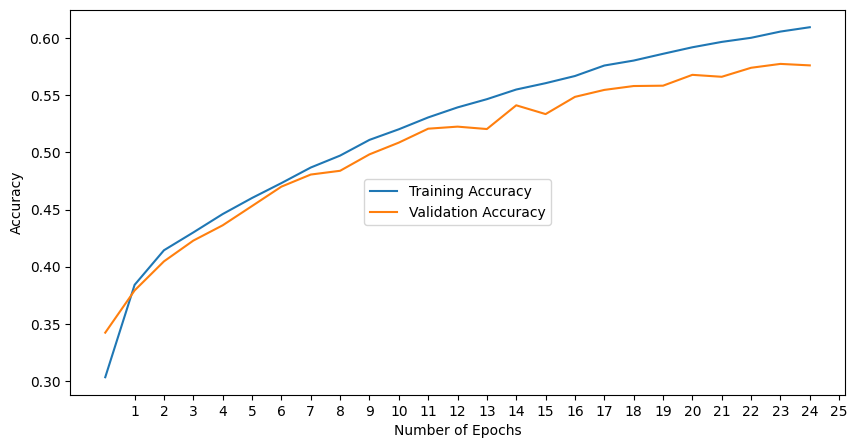

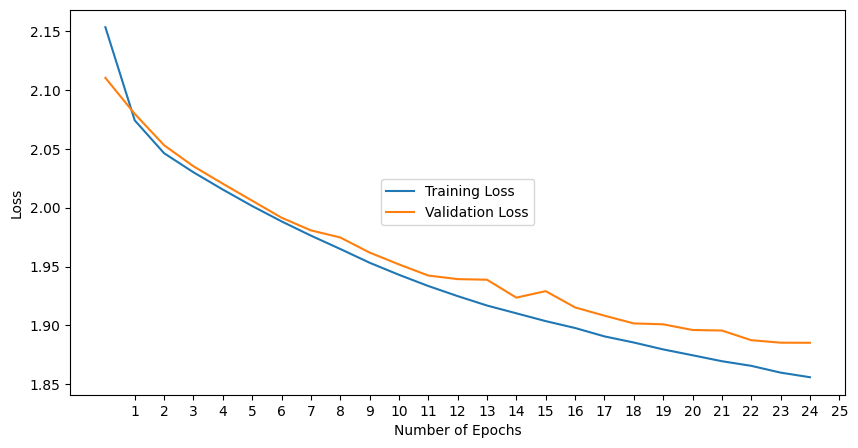

In [118]:
padding = 0
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.0001
momentum = "N.A."

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

## NAdam with lr 0.0001

Epoch 1 trained with training loss: 2.1510231252670287 and validation loss: 2.105897653217133 and training accuracy 0.3073 and validation accuracy 0.3527356230031949
Epoch 2 trained with training loss: 2.0732952607154846 and validation loss: 2.0695317602766967 and training accuracy 0.3863 and validation accuracy 0.3876797124600639
Epoch 3 trained with training loss: 2.0462248653411863 and validation loss: 2.046547366407352 and training accuracy 0.415525 and validation accuracy 0.41423722044728434
Epoch 4 trained with training loss: 2.0257609219551087 and validation loss: 2.0351528797667626 and training accuracy 0.435125 and validation accuracy 0.42511980830670926
Epoch 5 trained with training loss: 2.008176997756958 and validation loss: 2.0117527665421604 and training accuracy 0.45355 and validation accuracy 0.45227635782747605
Epoch 6 trained with training loss: 1.9916017539978028 and validation loss: 2.0031065301011544 and training accuracy 0.47135 and validation accuracy 0.458566293

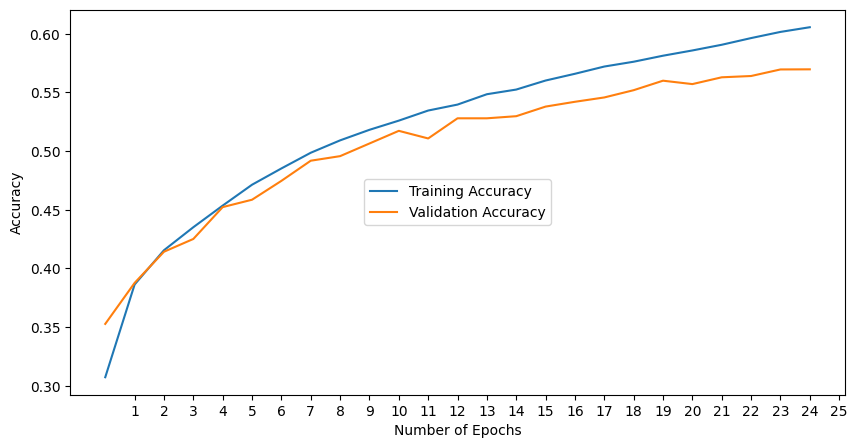

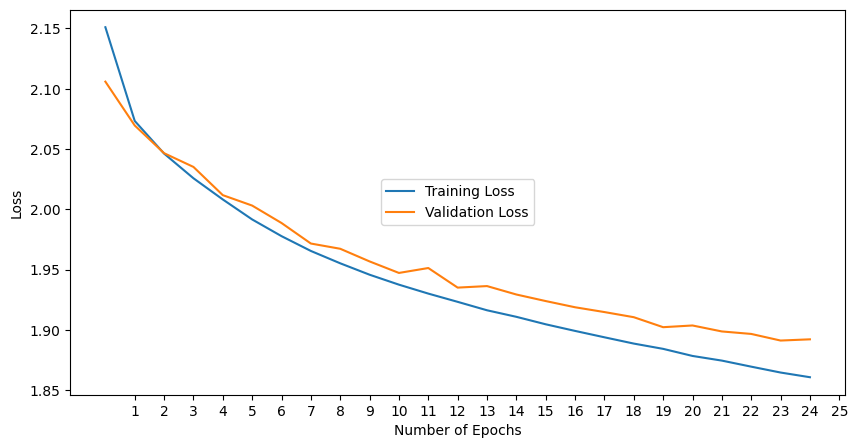

In [119]:
padding = 0
act_val = "ReLU"
optimizer_val = "NAdam"
num_epochs = 25
lr = 0.0001
momentum = "N.A."

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

# Experiments with batch sizes

## Batch Size = 8

In [120]:
batch_size = 8

In [121]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

Epoch 1 trained with training loss: 2.2533499079227446 and validation loss: 2.160706303977966 and training accuracy 0.190175 and validation accuracy 0.288
Epoch 2 trained with training loss: 2.1269313233613967 and validation loss: 2.1214718271255495 and training accuracy 0.3275 and validation accuracy 0.3292
Epoch 3 trained with training loss: 2.08177827603817 and validation loss: 2.0848122608184814 and training accuracy 0.374425 and validation accuracy 0.3691
Epoch 4 trained with training loss: 2.0496474633932116 and validation loss: 2.0510793633461 and training accuracy 0.407375 and validation accuracy 0.4061
Epoch 5 trained with training loss: 2.021039919114113 and validation loss: 2.026621676635742 and training accuracy 0.438075 and validation accuracy 0.4317
Epoch 6 trained with training loss: 1.995545885181427 and validation loss: 2.002800467777252 and training accuracy 0.462725 and validation accuracy 0.456
Epoch 7 trained with training loss: 1.971589581799507 and validation los

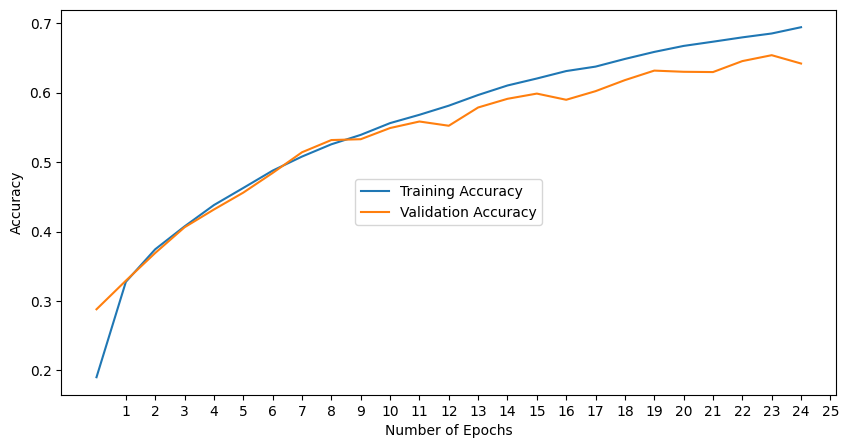

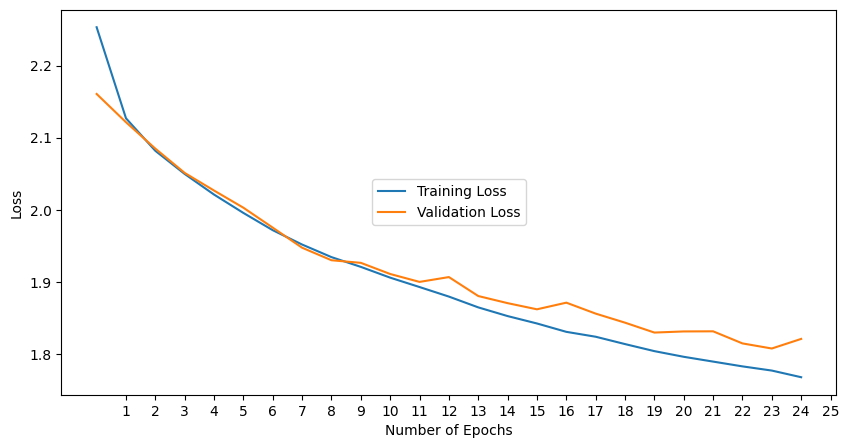

In [122]:
padding = 0
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 25
lr = 0.01
momentum = 0

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)


accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

Epoch 1 trained with training loss: 2.1036646963596346 and validation loss: 2.075307208633423 and training accuracy 0.348275 and validation accuracy 0.382
Epoch 2 trained with training loss: 2.040988477730751 and validation loss: 2.026555465888977 and training accuracy 0.4152 and validation accuracy 0.4321
Epoch 3 trained with training loss: 2.0167640414476393 and validation loss: 2.042574015045166 and training accuracy 0.44125 and validation accuracy 0.4155
Epoch 4 trained with training loss: 2.0074048312187194 and validation loss: 2.036736566257477 and training accuracy 0.45095 and validation accuracy 0.4227
Epoch 5 trained with training loss: 2.0140526553869247 and validation loss: 2.072738592529297 and training accuracy 0.4456 and validation accuracy 0.3876
Epoch 6 trained with training loss: 2.0133186846256255 and validation loss: 2.0108213742256162 and training accuracy 0.446975 and validation accuracy 0.4495
Epoch 7 trained with training loss: 2.0159618180036545 and validation l

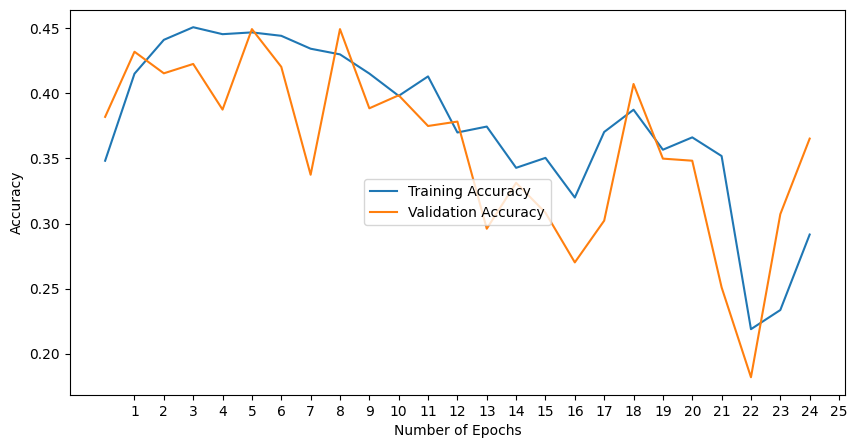

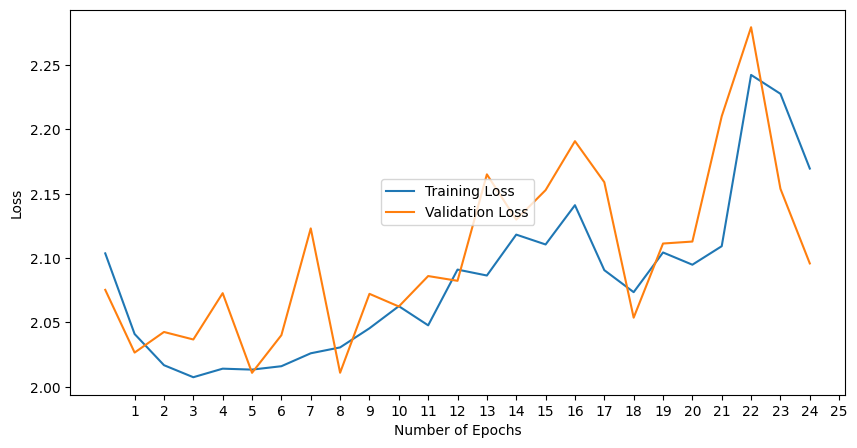

In [123]:
padding = 0
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = "N.A."

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

## Batch Size = 16

In [125]:
batch_size = 16

In [126]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

Epoch 1 trained with training loss: 2.2956891437530516 and validation loss: 2.2712961868286135 and training accuracy 0.157575 and validation accuracy 0.181
Epoch 2 trained with training loss: 2.200094039106369 and validation loss: 2.154327419090271 and training accuracy 0.255525 and validation accuracy 0.3039
Epoch 3 trained with training loss: 2.129009908103943 and validation loss: 2.1203090057373046 and training accuracy 0.325225 and validation accuracy 0.3351
Epoch 4 trained with training loss: 2.1002754256248473 and validation loss: 2.097100259017944 and training accuracy 0.3548 and validation accuracy 0.3628
Epoch 5 trained with training loss: 2.0762651300907136 and validation loss: 2.0772828205108644 and training accuracy 0.380425 and validation accuracy 0.3786
Epoch 6 trained with training loss: 2.057708870458603 and validation loss: 2.072171424293518 and training accuracy 0.39945 and validation accuracy 0.3867
Epoch 7 trained with training loss: 2.0431918213367464 and validatio

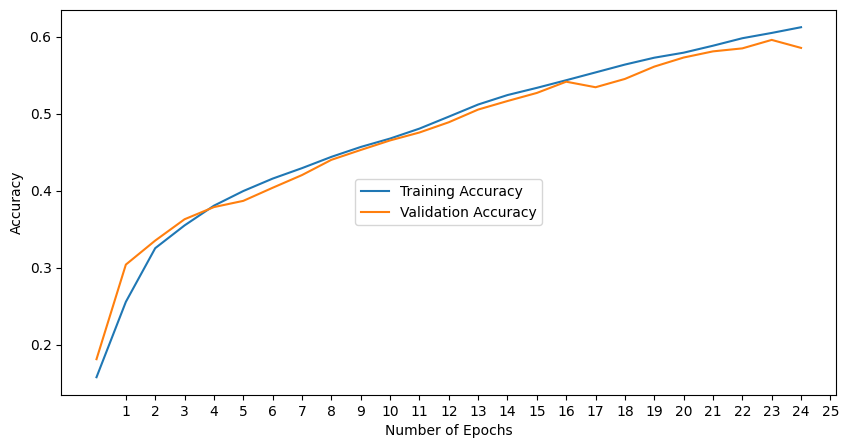

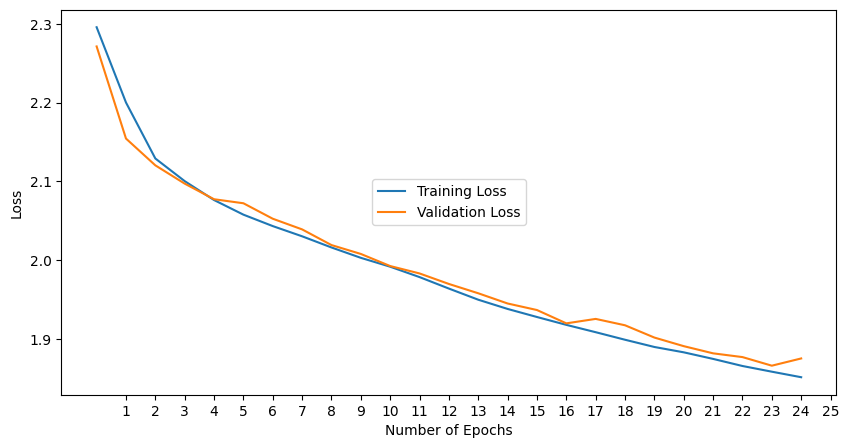

In [127]:
padding = 0
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 25
lr = 0.01
momentum = 0

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)


accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

Epoch 1 trained with training loss: 2.0874277212142944 and validation loss: 2.028888095474243 and training accuracy 0.366175 and validation accuracy 0.4278
Epoch 2 trained with training loss: 1.992395076417923 and validation loss: 1.9665723850250245 and training accuracy 0.464775 and validation accuracy 0.4905
Epoch 3 trained with training loss: 1.9472304096221924 and validation loss: 1.941312283706665 and training accuracy 0.5097 and validation accuracy 0.5135
Epoch 4 trained with training loss: 1.9186593833446504 and validation loss: 1.9161532932281493 and training accuracy 0.539175 and validation accuracy 0.5433
Epoch 5 trained with training loss: 1.897282810974121 and validation loss: 1.9049780443191529 and training accuracy 0.561225 and validation accuracy 0.5541
Epoch 6 trained with training loss: 1.8824414937973022 and validation loss: 1.8937195823669433 and training accuracy 0.575875 and validation accuracy 0.5655
Epoch 7 trained with training loss: 1.8729000996112823 and valid

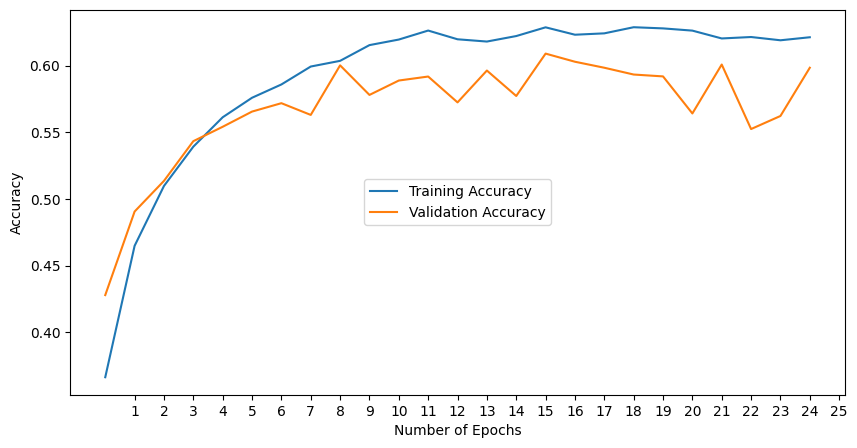

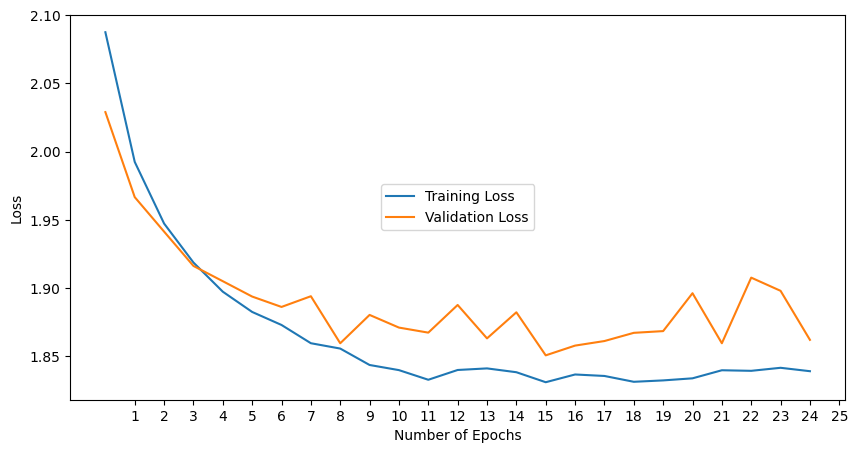

In [128]:
padding = 0
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = "N.A."

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

## Batch Size = 32

In [129]:
batch_size = 32

In [130]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

Epoch 1 trained with training loss: 2.3016379472732544 and validation loss: 2.300365358876725 and training accuracy 0.12855 and validation accuracy 0.15615015974440893
Epoch 2 trained with training loss: 2.294079260826111 and validation loss: 2.280476050635877 and training accuracy 0.14495 and validation accuracy 0.16353833865814696
Epoch 3 trained with training loss: 2.252151505279541 and validation loss: 2.2258440846452316 and training accuracy 0.198375 and validation accuracy 0.21944888178913738
Epoch 4 trained with training loss: 2.191119024658203 and validation loss: 2.1651382221581454 and training accuracy 0.26375 and validation accuracy 0.29113418530351437
Epoch 5 trained with training loss: 2.1380158224105834 and validation loss: 2.1304907227476564 and training accuracy 0.318175 and validation accuracy 0.32807507987220447
Epoch 6 trained with training loss: 2.1137313658714296 and validation loss: 2.1137024758341973 and training accuracy 0.3422 and validation accuracy 0.33875798

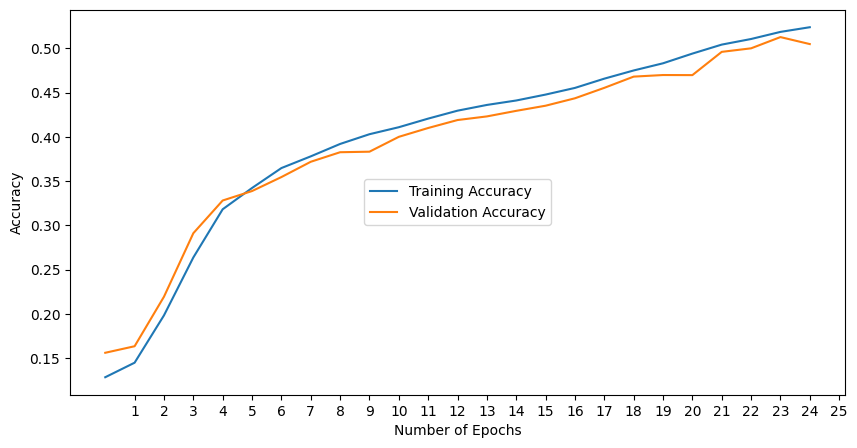

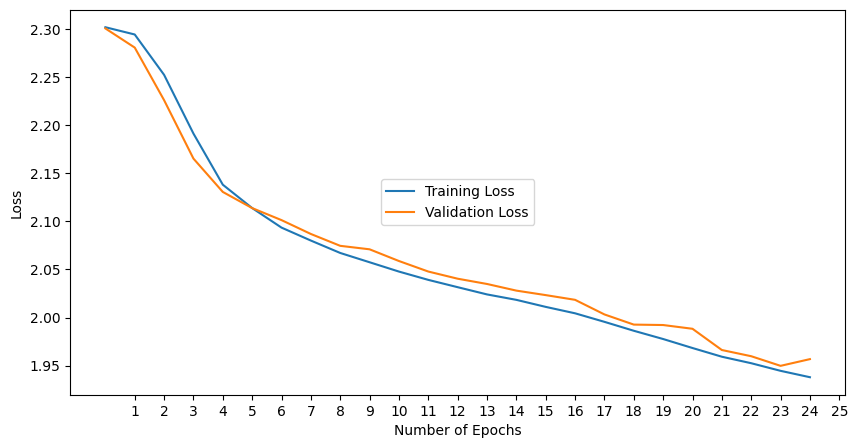

In [131]:
padding = 0
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 25
lr = 0.01
momentum = 0

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)


accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

Epoch 1 trained with training loss: 2.092614913845062 and validation loss: 2.0398974079674423 and training accuracy 0.360925 and validation accuracy 0.4143370607028754
Epoch 2 trained with training loss: 1.9948405626296997 and validation loss: 2.0016055769813708 and training accuracy 0.46275 and validation accuracy 0.4533746006389776
Epoch 3 trained with training loss: 1.9485176280975343 and validation loss: 1.9726597402042474 and training accuracy 0.508675 and validation accuracy 0.4836261980830671
Epoch 4 trained with training loss: 1.9197072551727294 and validation loss: 1.9143146718272006 and training accuracy 0.53805 and validation accuracy 0.5422324281150159
Epoch 5 trained with training loss: 1.8902322638511657 and validation loss: 1.9004830887523323 and training accuracy 0.569075 and validation accuracy 0.5567092651757188
Epoch 6 trained with training loss: 1.8702947688102722 and validation loss: 1.9024841834942754 and training accuracy 0.5892 and validation accuracy 0.55561102

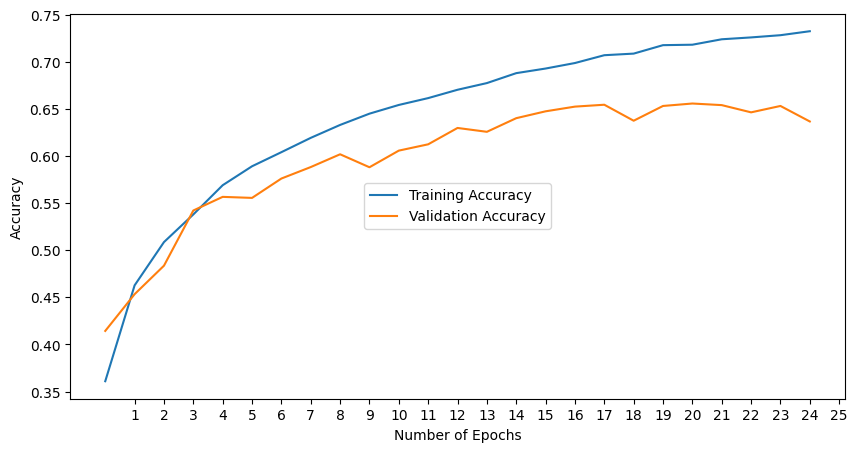

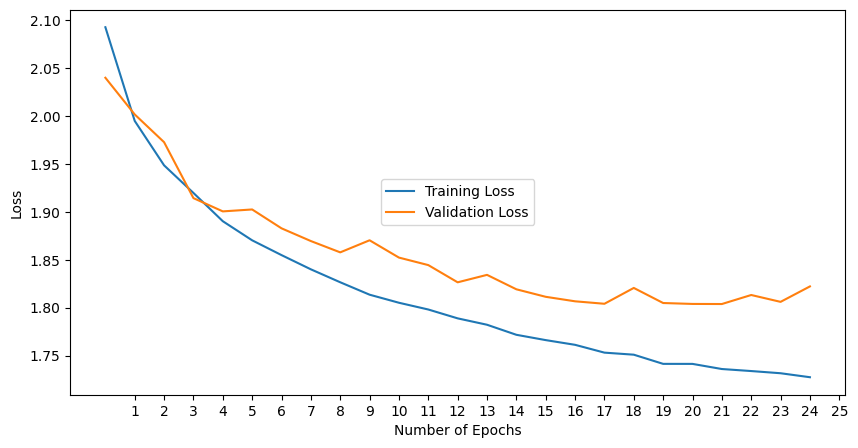

In [134]:
padding = 0
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = "N.A."

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

## Batch Size = 64

In [ ]:
batch_size = 64

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

Epoch 1 trained with training loss: 2.302028540802002 and validation loss: 2.3015106893648767 and training accuracy 0.113075 and validation accuracy 0.11365445859872611
Epoch 2 trained with training loss: 2.300790979003906 and validation loss: 2.2997495277672058 and training accuracy 0.105875 and validation accuracy 0.10111464968152867
Epoch 3 trained with training loss: 2.297846239089966 and validation loss: 2.294580892392784 and training accuracy 0.1133 and validation accuracy 0.13863455414012738
Epoch 4 trained with training loss: 2.2849075912475585 and validation loss: 2.268189515277838 and training accuracy 0.178175 and validation accuracy 0.1956608280254777
Epoch 5 trained with training loss: 2.2499052684783933 and validation loss: 2.2300448022830257 and training accuracy 0.1986 and validation accuracy 0.22601512738853502
Epoch 6 trained with training loss: 2.221192751312256 and validation loss: 2.202745407250277 and training accuracy 0.230625 and validation accuracy 0.2587579617

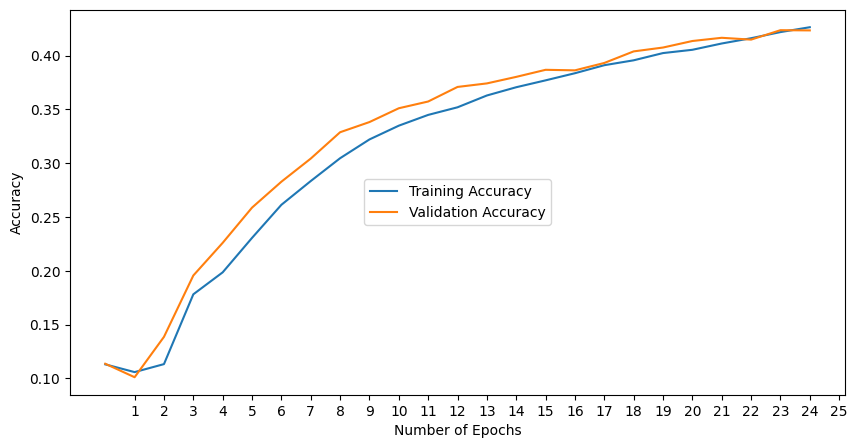

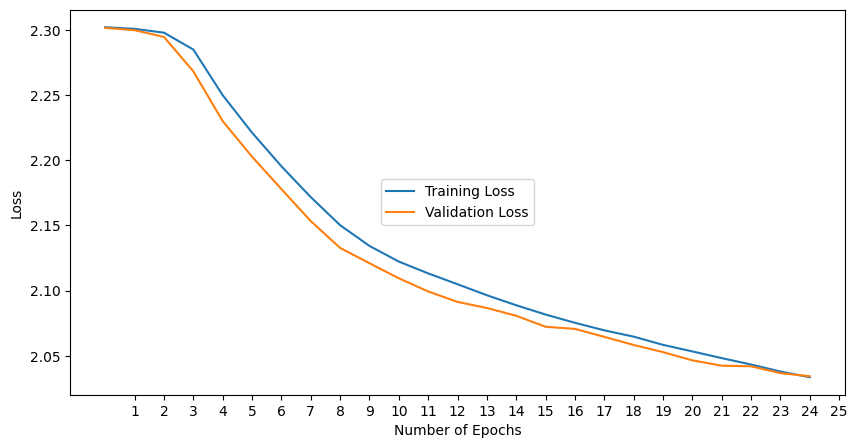

In [ ]:
padding = 0
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 25
lr = 0.01
momentum = 0

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

Epoch 1 trained with training loss: 2.114799271774292 and validation loss: 2.040425091792064 and training accuracy 0.33755 and validation accuracy 0.41490843949044587
Epoch 2 trained with training loss: 2.0109176445007324 and validation loss: 2.0131058100682155 and training accuracy 0.446225 and validation accuracy 0.4411823248407643
Epoch 3 trained with training loss: 1.9656251152038575 and validation loss: 1.9387656260447896 and training accuracy 0.4925 and validation accuracy 0.5198049363057324
Epoch 4 trained with training loss: 1.9297735261917115 and validation loss: 1.9044073554360943 and training accuracy 0.5292 and validation accuracy 0.5576234076433121
Epoch 5 trained with training loss: 1.8974700397491455 and validation loss: 1.9219620637832933 and training accuracy 0.561575 and validation accuracy 0.5364251592356688
Epoch 6 trained with training loss: 1.8791145893096923 and validation loss: 1.8842067361637285 and training accuracy 0.57985 and validation accuracy 0.5754378980

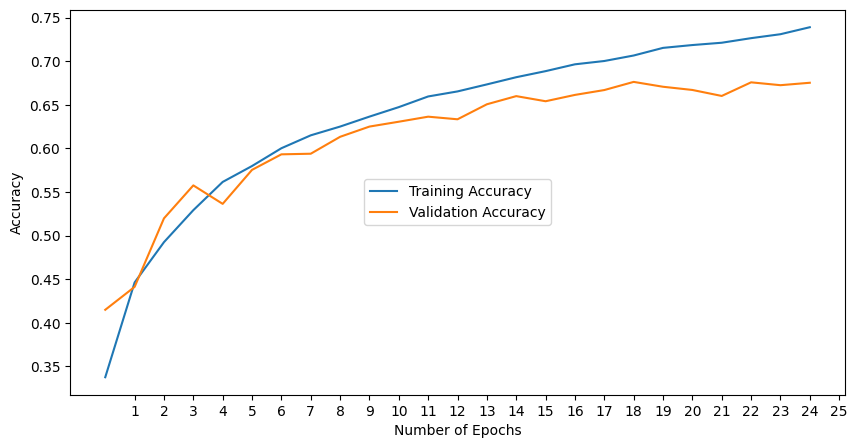

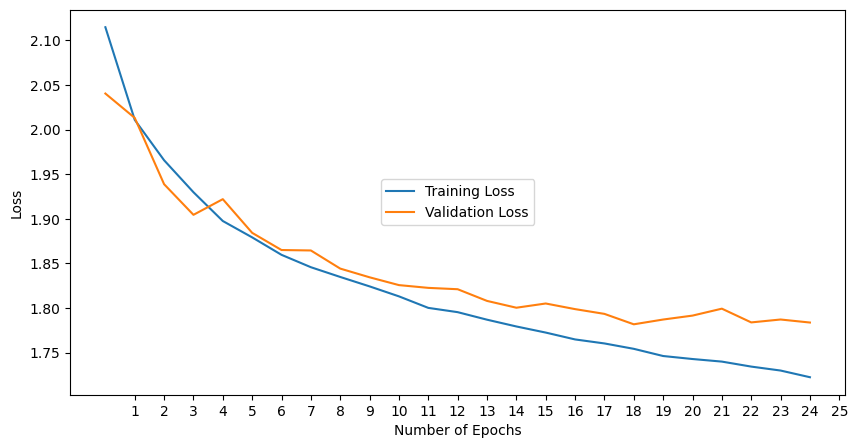

In [ ]:
padding = 0
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = "N.A."

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

## Batch Size = 128

In [ ]:
batch_size = 128

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

Epoch 1 trained with training loss: 2.3024454909010816 and validation loss: 2.302281509471845 and training accuracy 0.10328474440894568 and validation accuracy 0.11224287974683544
Epoch 2 trained with training loss: 2.302200217597401 and validation loss: 2.3020311156405677 and training accuracy 0.11316892971246006 and validation accuracy 0.11471518987341772
Epoch 3 trained with training loss: 2.3018954782821117 and validation loss: 2.301669881313662 and training accuracy 0.1161641373801917 and validation accuracy 0.11916534810126582
Epoch 4 trained with training loss: 2.3014630303977017 and validation loss: 2.301124841352052 and training accuracy 0.12025758785942492 and validation accuracy 0.12598892405063292
Epoch 5 trained with training loss: 2.300811309783984 and validation loss: 2.3002825447275668 and training accuracy 0.125 and validation accuracy 0.13479034810126583
Epoch 6 trained with training loss: 2.2998043614835404 and validation loss: 2.298999276342271 and training accuracy

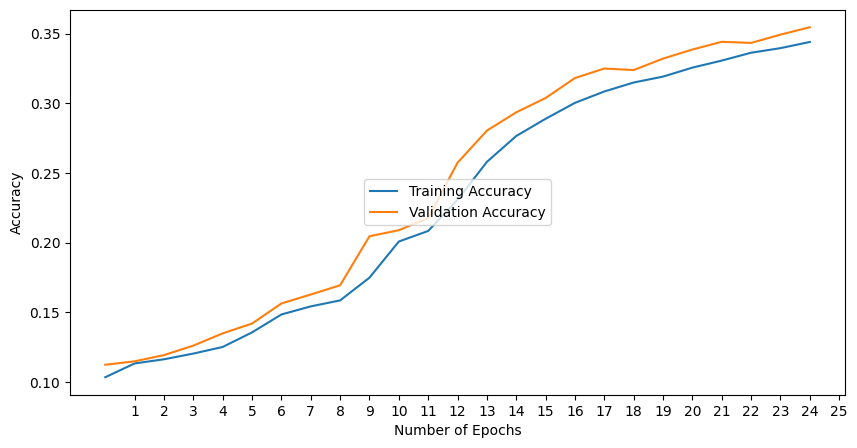

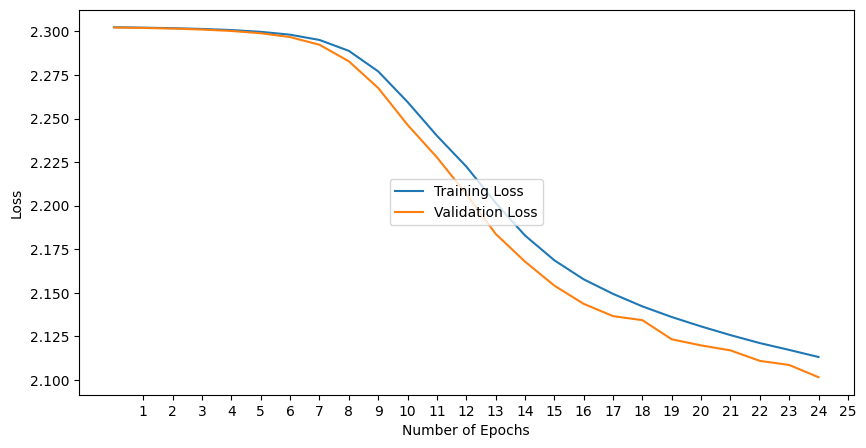

In [ ]:
padding = 0
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 25
lr = 0.01
momentum = 0

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

Epoch 1 trained with training loss: 2.122351889031383 and validation loss: 2.0641518242751498 and training accuracy 0.3309205271565495 and validation accuracy 0.3916139240506329
Epoch 2 trained with training loss: 2.032191488689508 and validation loss: 2.0038346157798284 and training accuracy 0.4248202875399361 and validation accuracy 0.4546083860759494
Epoch 3 trained with training loss: 1.985300144448448 and validation loss: 1.9601826200002357 and training accuracy 0.47266873003194887 and validation accuracy 0.4958465189873418
Epoch 4 trained with training loss: 1.9509851566899699 and validation loss: 1.9424083459226391 and training accuracy 0.5083865814696485 and validation accuracy 0.5150316455696202
Epoch 5 trained with training loss: 1.9236158939977042 and validation loss: 1.9118575929086419 and training accuracy 0.5363668130990416 and validation accuracy 0.5488528481012658
Epoch 6 trained with training loss: 1.9036595966107548 and validation loss: 1.913111686706543 and training 

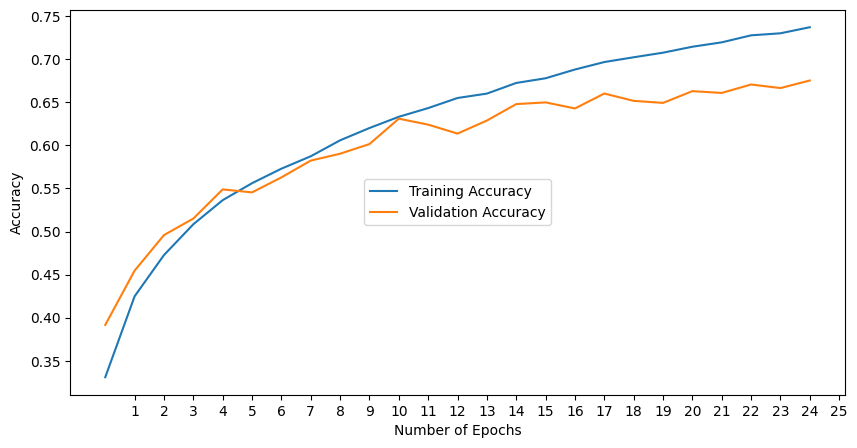

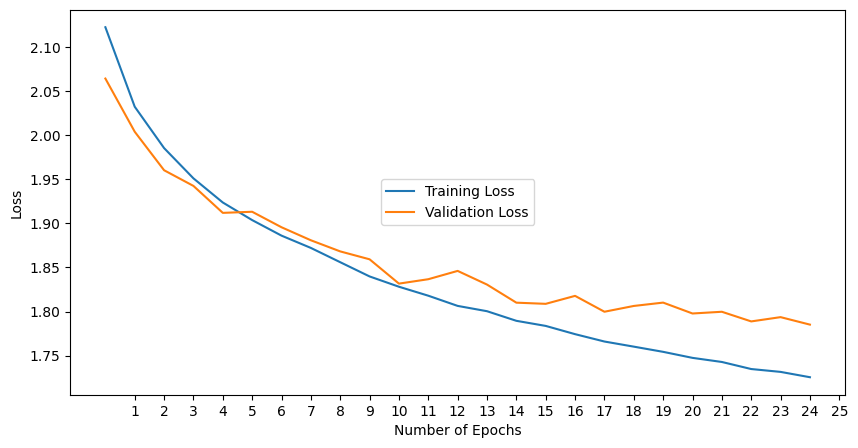

In [ ]:
padding = 0
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = "N.A."

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

## Batch Size = 256

In [135]:
batch_size = 256

In [136]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

Epoch 1 trained with training loss: 2.302285258177739 and validation loss: 2.3021163403987885 and training accuracy 0.10561803343949044 and validation accuracy 0.1166015625
Epoch 2 trained with training loss: 2.3020274654315536 and validation loss: 2.301891899108887 and training accuracy 0.11793391719745223 and validation accuracy 0.1271484375
Epoch 3 trained with training loss: 2.3017437290993468 and validation loss: 2.301573169231415 and training accuracy 0.13358379777070065 and validation accuracy 0.13994140625
Epoch 4 trained with training loss: 2.3014289649428834 and validation loss: 2.3013059496879578 and training accuracy 0.14731787420382167 and validation accuracy 0.14931640625
Epoch 5 trained with training loss: 2.3010798533251333 and validation loss: 2.3008798718452455 and training accuracy 0.15406050955414013 and validation accuracy 0.1587890625
Epoch 6 trained with training loss: 2.30066405132318 and validation loss: 2.3004520177841186 and training accuracy 0.15963375796178

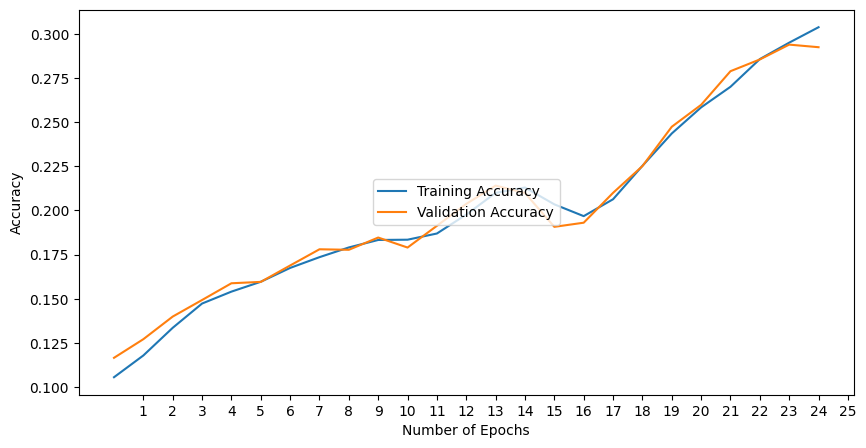

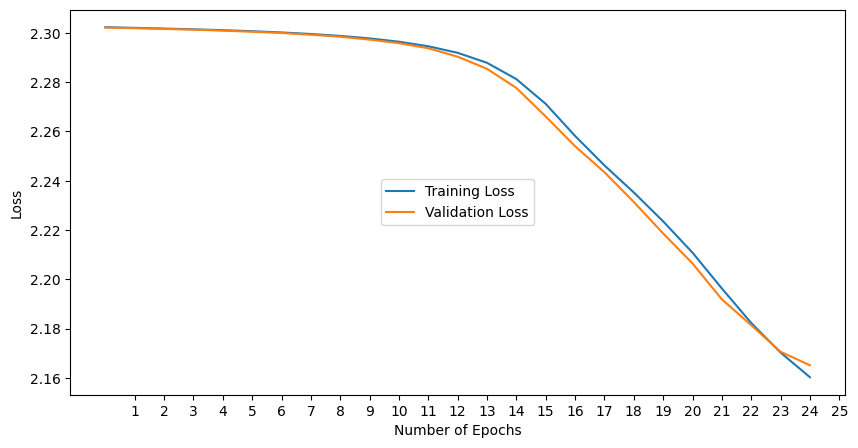

In [138]:
padding = 0
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 25
lr = 0.01
momentum = 0

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

Epoch 1 trained with training loss: 2.135845217735145 and validation loss: 2.0827080726623537 and training accuracy 0.3158091162420382 and validation accuracy 0.37470703125
Epoch 2 trained with training loss: 2.0459433330851757 and validation loss: 2.045789194107056 and training accuracy 0.41127587579617836 and validation accuracy 0.40771484375
Epoch 3 trained with training loss: 2.0053693306673863 and validation loss: 2.0011615574359896 and training accuracy 0.45163216560509556 and validation accuracy 0.4572265625
Epoch 4 trained with training loss: 1.9819137017438366 and validation loss: 1.9885503828525544 and training accuracy 0.47735867834394907 and validation accuracy 0.46962890625
Epoch 5 trained with training loss: 1.9549721942585745 and validation loss: 1.949814036488533 and training accuracy 0.5043292197452229 and validation accuracy 0.509375
Epoch 6 trained with training loss: 1.9346517354819426 and validation loss: 1.9385058462619782 and training accuracy 0.525328423566879 a

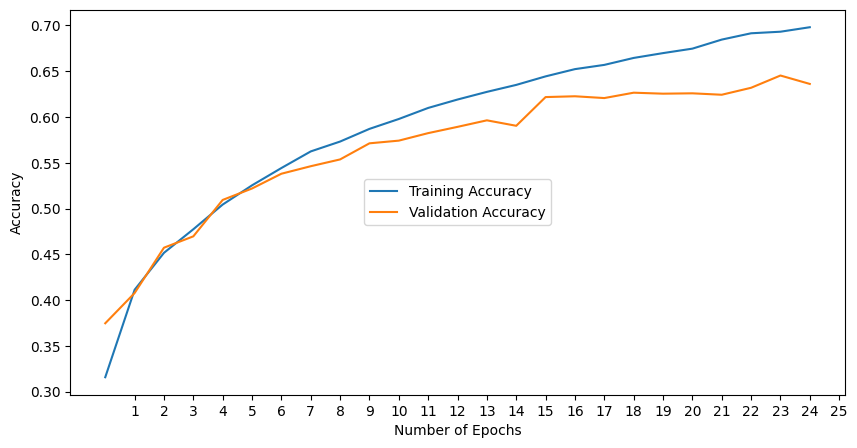

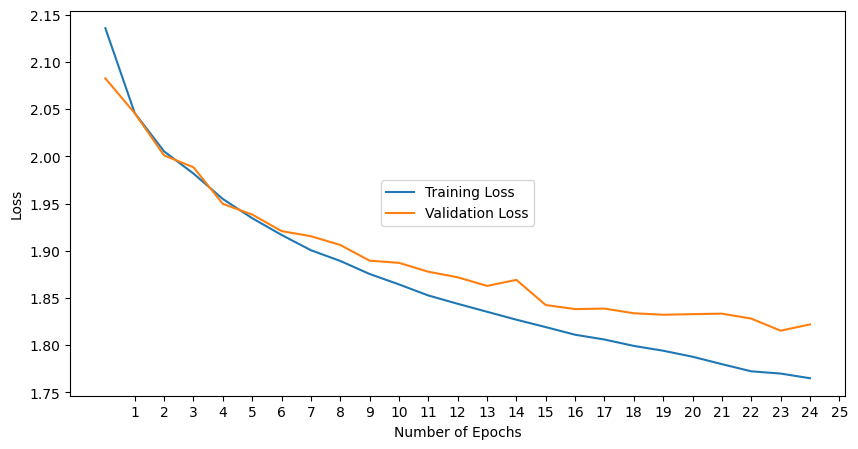

In [139]:
padding = 0
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = "N.A."

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

## Batch Size = 512

In [140]:
batch_size = 512

In [141]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False)

Epoch 1 trained with training loss: 2.3025964543789246 and validation loss: 2.302532637119293 and training accuracy 0.09656843354430379 and validation accuracy 0.09892003676470588
Epoch 2 trained with training loss: 2.3024774684181697 and validation loss: 2.30242178440094 and training accuracy 0.10035106803797468 and validation accuracy 0.10100528492647058
Epoch 3 trained with training loss: 2.30234759366965 and validation loss: 2.3022793769836425 and training accuracy 0.10087025316455696 and validation accuracy 0.10302734375
Epoch 4 trained with training loss: 2.302216913126692 and validation loss: 2.302169716358185 and training accuracy 0.1020075158227848 and validation accuracy 0.10114889705882353
Epoch 5 trained with training loss: 2.302070391329029 and validation loss: 2.3020240664482117 and training accuracy 0.10230419303797468 and validation accuracy 0.10197035845588236
Epoch 6 trained with training loss: 2.3019379482993596 and validation loss: 2.3018751740455627 and training ac

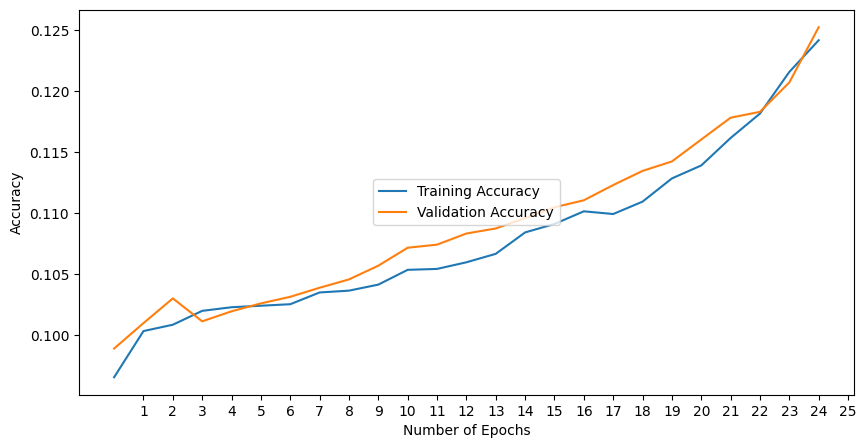

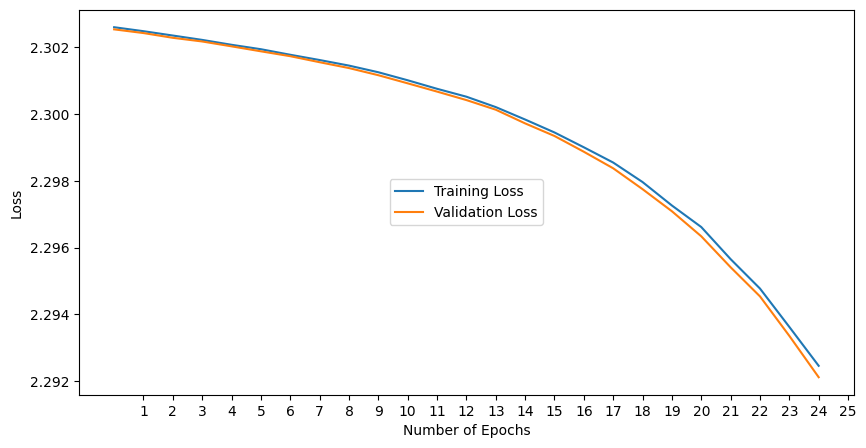

In [142]:
padding = 0
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 25
lr = 0.01
momentum = 0

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

Epoch 1 trained with training loss: 2.166238274755357 and validation loss: 2.124003756046295 and training accuracy 0.2813736155063291 and validation accuracy 0.33073299632352937
Epoch 2 trained with training loss: 2.0754720289495925 and validation loss: 2.0803079128265383 and training accuracy 0.3818730221518987 and validation accuracy 0.3701459099264706
Epoch 3 trained with training loss: 2.0450583771814275 and validation loss: 2.044810175895691 and training accuracy 0.4124307753164557 and validation accuracy 0.4154526654411764
Epoch 4 trained with training loss: 2.0166460849061796 and validation loss: 2.023660880327225 and training accuracy 0.4439032832278481 and validation accuracy 0.4352711397058823
Epoch 5 trained with training loss: 1.9877818219269379 and validation loss: 1.9847537517547607 and training accuracy 0.47226068037974683 and validation accuracy 0.47809053308823535
Epoch 6 trained with training loss: 1.9661878437935552 and validation loss: 1.986088901758194 and training

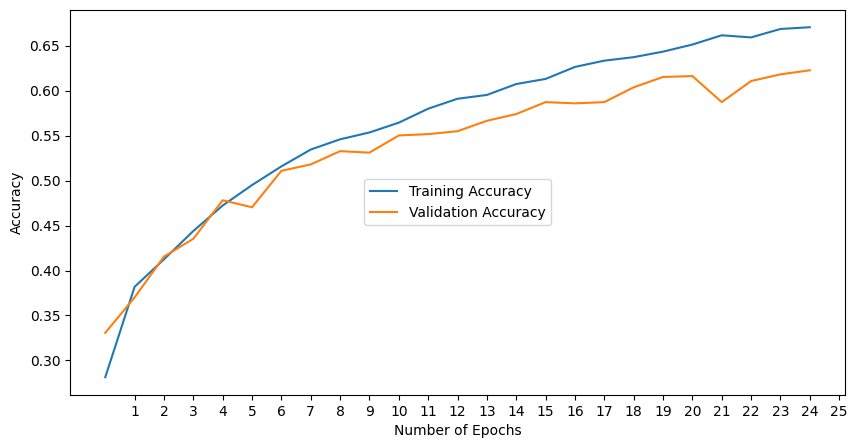

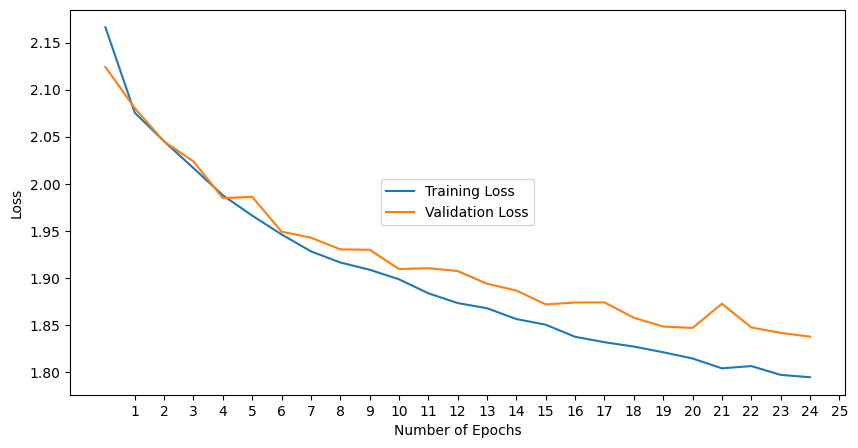

In [143]:
padding = 0
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = "N.A."

model_accuracy, ex_time = train(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

# Padding

## Padding = 1

In [145]:
# Model creation
num_of_channels = 3

def baseline_padding1(padding=1):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 128, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 8 * 8 , 10),
        nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [146]:
def train_padding1(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_padding1()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 2.142513655409028 and validation loss: 2.095803916454315 and training accuracy 0.31269778481012656 and validation accuracy 0.35617532169117644
Epoch 2 trained with training loss: 2.044635911531086 and validation loss: 2.043222653865814 and training accuracy 0.41324663765822783 and validation accuracy 0.4120978860294118
Epoch 3 trained with training loss: 2.011158980900728 and validation loss: 2.006691205501556 and training accuracy 0.4467464398734177 and validation accuracy 0.4505170036764706
Epoch 4 trained with training loss: 1.974688786494581 and validation loss: 1.9655632197856903 and training accuracy 0.48439972310126583 and validation accuracy 0.49514016544117645
Epoch 5 trained with training loss: 1.9383343563804143 and validation loss: 1.941175365447998 and training accuracy 0.5218799446202531 and validation accuracy 0.5218520220588235
Epoch 6 trained with training loss: 1.9132856945448284 and validation loss: 1.9242437660694123 and training 

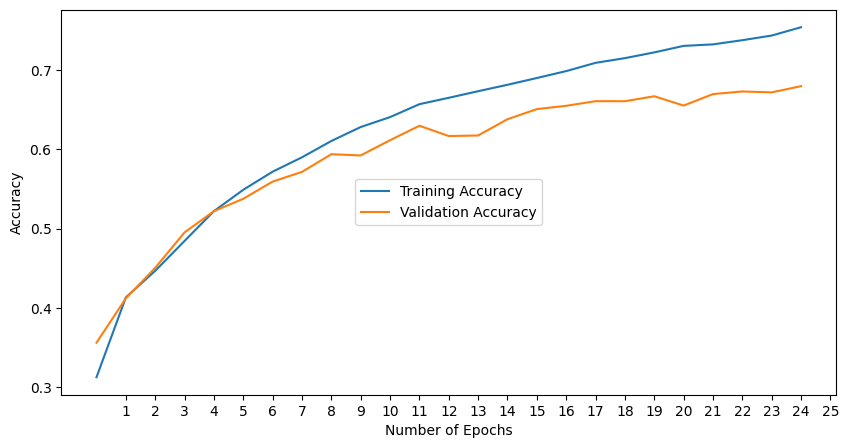

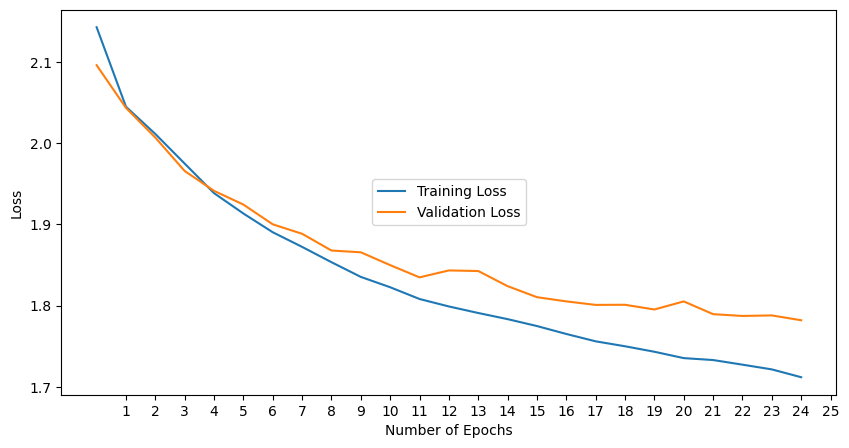

0.6793370863970588


In [147]:
padding = 1
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_padding1(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy)

## Padding = 2

In [148]:
# Model creation
num_of_channels = 3

def baseline_padding2(padding=2):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 128, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 11 * 11 , 10),
        nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [149]:
def train_padding1(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_padding1()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

In [150]:
def train_padding2(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_padding2()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 2.1275657007965862 and validation loss: 2.054127609729767 and training accuracy 0.32819916930379744 and validation accuracy 0.40622127757352944
Epoch 2 trained with training loss: 2.0189118174057974 and validation loss: 2.0235713481903077 and training accuracy 0.4384889240506329 and validation accuracy 0.4349609375
Epoch 3 trained with training loss: 1.988151339036 and validation loss: 1.9995534300804139 and training accuracy 0.4708020174050633 and validation accuracy 0.45656594669117645
Epoch 4 trained with training loss: 1.9565658131732215 and validation loss: 1.9616564512252808 and training accuracy 0.5029667721518988 and validation accuracy 0.4968290441176471
Epoch 5 trained with training loss: 1.9359324461297145 and validation loss: 1.944082647562027 and training accuracy 0.5226463607594937 and validation accuracy 0.5149126838235294
Epoch 6 trained with training loss: 1.9110479671743852 and validation loss: 1.9223800480365754 and training accura

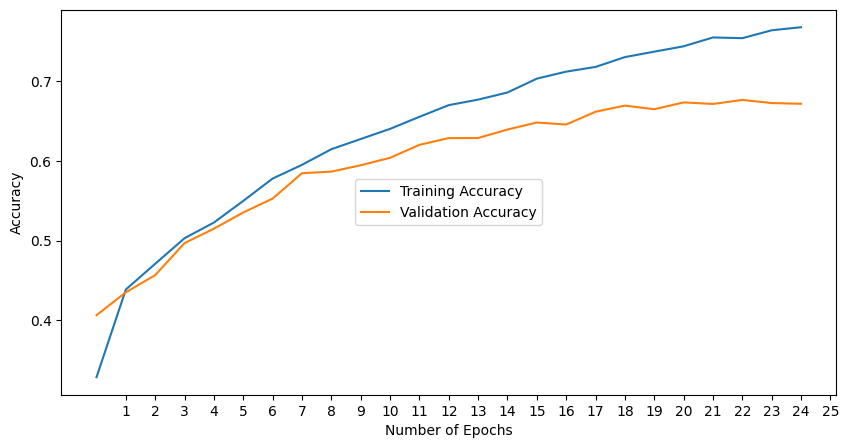

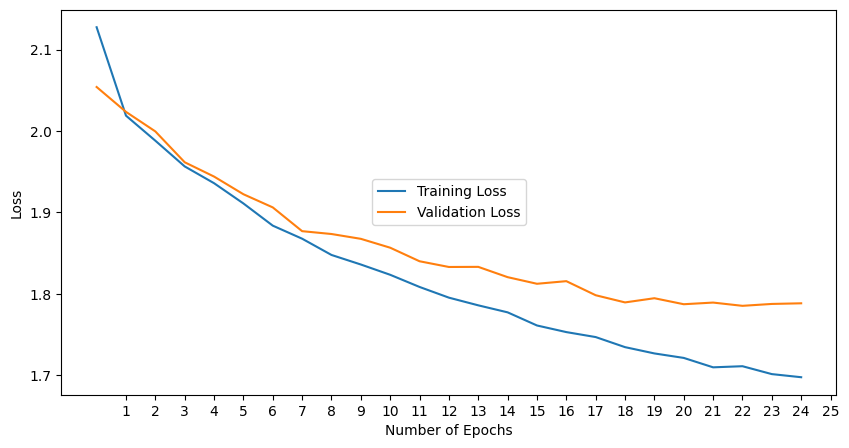

0.6719094669117647


In [151]:
padding = 2
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_padding2(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy)

## Padding = 3

In [152]:
# Model creation
num_of_channels = 3

def baseline_padding3(padding=3):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 128, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 15 * 15 , 10),
        nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [153]:
def train_padding3(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_padding3()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 2.155084039591536 and validation loss: 2.094668245315552 and training accuracy 0.2990011867088608 and validation accuracy 0.3605755974264706
Epoch 2 trained with training loss: 2.0548963999446435 and validation loss: 2.0445423483848573 and training accuracy 0.40160205696202533 and validation accuracy 0.41004710477941175
Epoch 3 trained with training loss: 2.0194806388661832 and validation loss: 2.0205089449882507 and training accuracy 0.43888449367088606 and validation accuracy 0.4359087775735294
Epoch 4 trained with training loss: 1.9927925520305392 and validation loss: 1.9898030638694764 and training accuracy 0.46556071993670883 and validation accuracy 0.46877872242647056
Epoch 5 trained with training loss: 1.9666210065914105 and validation loss: 1.9702661871910094 and training accuracy 0.49263251582278483 and validation accuracy 0.48888442095588236
Epoch 6 trained with training loss: 1.9397454654114157 and validation loss: 1.9416600048542023 and t

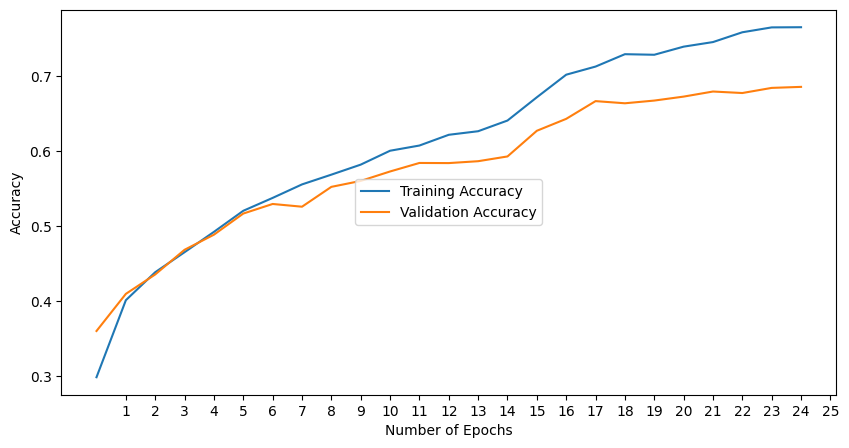

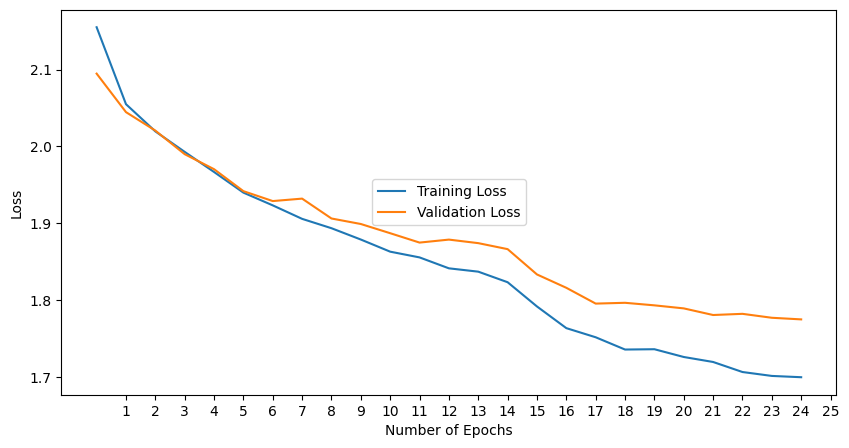

0.6857823988970588


In [154]:
padding = 3
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_padding3(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy)

# Kernel Experiments

## Kernel 5x5 in first layer

In [155]:
num_of_channels = 3

def baseline_kernel1(padding=3):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=5, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 128, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 14 * 14 , 10),
        nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [156]:
trial, lo= baseline_kernel1()

In [157]:
summary(trial, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 34, 34]          2,432
├─ReLU: 1-2                              [-1, 32, 34, 34]          --
├─MaxPool2d: 1-3                         [-1, 32, 17, 17]          --
├─Conv2d: 1-4                            [-1, 128, 21, 21]         36,992
├─ReLU: 1-5                              [-1, 128, 21, 21]         --
├─MaxPool2d: 1-6                         [-1, 128, 10, 10]         --
├─Conv2d: 1-7                            [-1, 32, 14, 14]          36,896
├─ReLU: 1-8                              [-1, 32, 14, 14]          --
├─Flatten: 1-9                           [-1, 6272]                --
├─Linear: 1-10                           [-1, 10]                  62,730
├─Softmax: 1-11                          [-1, 10]                  --
Total params: 139,050
Trainable params: 139,050
Non-trainable params: 0
Total mult-adds (M): 26.32
Input size (MB): 0.01
Forward/backward pa

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 34, 34]          2,432
├─ReLU: 1-2                              [-1, 32, 34, 34]          --
├─MaxPool2d: 1-3                         [-1, 32, 17, 17]          --
├─Conv2d: 1-4                            [-1, 128, 21, 21]         36,992
├─ReLU: 1-5                              [-1, 128, 21, 21]         --
├─MaxPool2d: 1-6                         [-1, 128, 10, 10]         --
├─Conv2d: 1-7                            [-1, 32, 14, 14]          36,896
├─ReLU: 1-8                              [-1, 32, 14, 14]          --
├─Flatten: 1-9                           [-1, 6272]                --
├─Linear: 1-10                           [-1, 10]                  62,730
├─Softmax: 1-11                          [-1, 10]                  --
Total params: 139,050
Trainable params: 139,050
Non-trainable params: 0
Total mult-adds (M): 26.32
Input size (MB): 0.01
Forward/backward pa

In [158]:
def train_kernel1(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_kernel1()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 2.127883817576155 and validation loss: 2.083029043674469 and training accuracy 0.32266119462025317 and validation accuracy 0.37243795955882353
Epoch 2 trained with training loss: 2.03410232218006 and validation loss: 2.0247019112110136 and training accuracy 0.42422369462025317 and validation accuracy 0.4333467371323529
Epoch 3 trained with training loss: 1.9988876219037213 and validation loss: 1.9912888169288636 and training accuracy 0.45937994462025317 and validation accuracy 0.46375804227941175
Epoch 4 trained with training loss: 1.974709512312201 and validation loss: 1.9877266705036163 and training accuracy 0.48227353639240506 and validation accuracy 0.4702550551470588
Epoch 5 trained with training loss: 1.9504964804347558 and validation loss: 1.9468547880649567 and training accuracy 0.508232792721519 and validation accuracy 0.5129653033088235
Epoch 6 trained with training loss: 1.9201171292534358 and validation loss: 1.9262438893318177 and traini

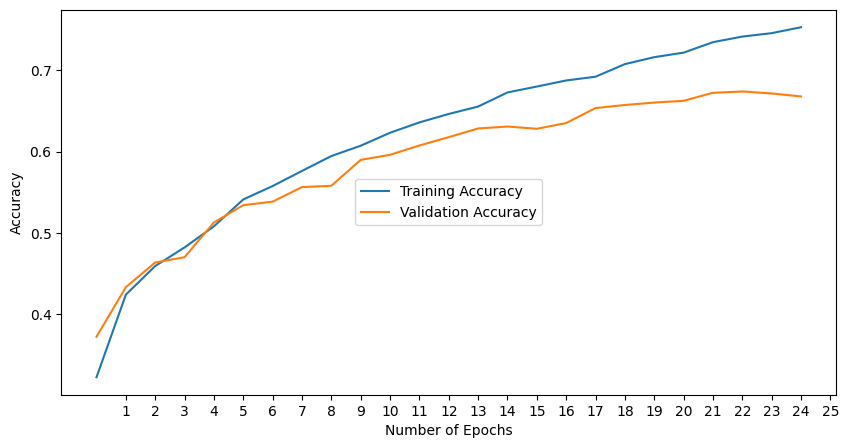

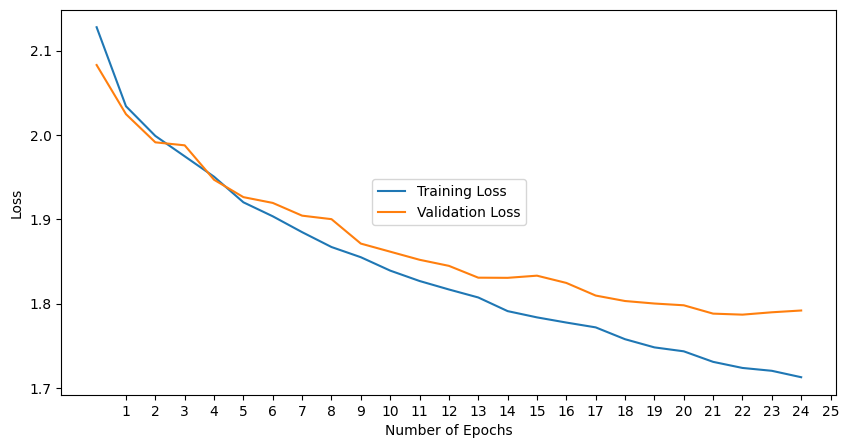

0.6679170496323529 128.48037099999783


In [159]:
padding = 3
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_padding3(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy, ex_time)

## Kernel 5x5 in first two layers

In [160]:
num_of_channels = 3

def baseline_kernel2(padding=3):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=5, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 128, kernel_size=5, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 13 * 13 , 10),
        nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [161]:
trial, lo= baseline_kernel2()

In [162]:
summary(trial, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 34, 34]          2,432
├─ReLU: 1-2                              [-1, 32, 34, 34]          --
├─MaxPool2d: 1-3                         [-1, 32, 17, 17]          --
├─Conv2d: 1-4                            [-1, 128, 19, 19]         102,528
├─ReLU: 1-5                              [-1, 128, 19, 19]         --
├─MaxPool2d: 1-6                         [-1, 128, 9, 9]           --
├─Conv2d: 1-7                            [-1, 32, 13, 13]          36,896
├─ReLU: 1-8                              [-1, 32, 13, 13]          --
├─Flatten: 1-9                           [-1, 5408]                --
├─Linear: 1-10                           [-1, 10]                  54,090
├─Softmax: 1-11                          [-1, 10]                  --
Total params: 195,946
Trainable params: 195,946
Non-trainable params: 0
Total mult-adds (M): 46.02
Input size (MB): 0.01
Forward/backward p

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 34, 34]          2,432
├─ReLU: 1-2                              [-1, 32, 34, 34]          --
├─MaxPool2d: 1-3                         [-1, 32, 17, 17]          --
├─Conv2d: 1-4                            [-1, 128, 19, 19]         102,528
├─ReLU: 1-5                              [-1, 128, 19, 19]         --
├─MaxPool2d: 1-6                         [-1, 128, 9, 9]           --
├─Conv2d: 1-7                            [-1, 32, 13, 13]          36,896
├─ReLU: 1-8                              [-1, 32, 13, 13]          --
├─Flatten: 1-9                           [-1, 5408]                --
├─Linear: 1-10                           [-1, 10]                  54,090
├─Softmax: 1-11                          [-1, 10]                  --
Total params: 195,946
Trainable params: 195,946
Non-trainable params: 0
Total mult-adds (M): 46.02
Input size (MB): 0.01
Forward/backward p

In [163]:
def train_kernel2(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_kernel2()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 2.1507337153712407 and validation loss: 2.0953255534172057 and training accuracy 0.3017701740506329 and validation accuracy 0.3587545955882353
Epoch 2 trained with training loss: 2.0525754886337473 and validation loss: 2.029107999801636 and training accuracy 0.40325850474683544 and validation accuracy 0.4246438419117647
Epoch 3 trained with training loss: 1.98384021354627 and validation loss: 1.9976828753948213 and training accuracy 0.47455992879746833 and validation accuracy 0.45799057904411766
Epoch 4 trained with training loss: 1.9455043967766097 and validation loss: 1.9584798634052276 and training accuracy 0.5127571202531646 and validation accuracy 0.4988166360294118
Epoch 5 trained with training loss: 1.907380786123155 and validation loss: 1.9169952929019929 and training accuracy 0.5536985759493671 and validation accuracy 0.5422564338235294
Epoch 6 trained with training loss: 1.8815270375601854 and validation loss: 1.9097751259803772 and trainin

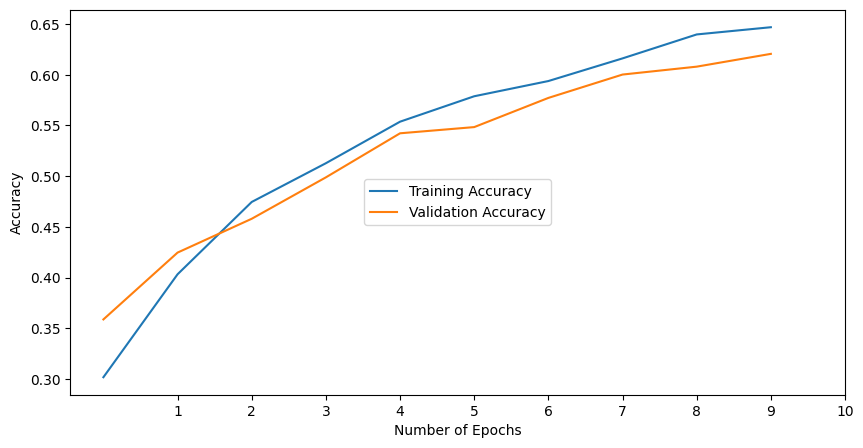

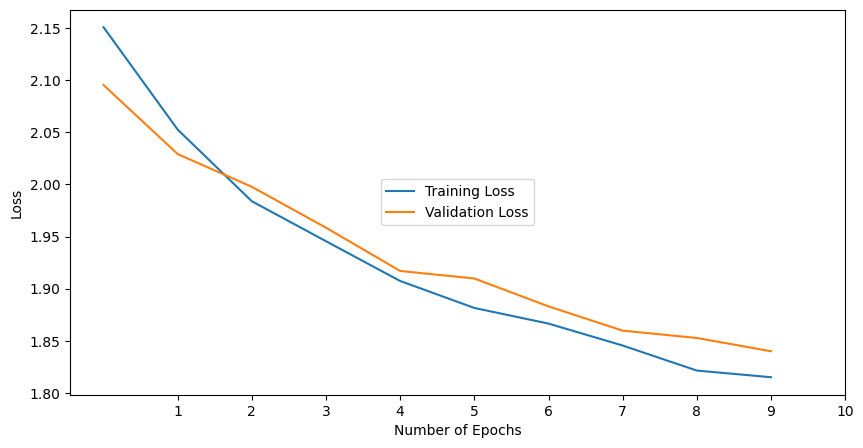

0.6205710018382353 48.76080799999909


In [164]:
padding = 3
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 10
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_kernel2(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy, ex_time)

## Kernel 5x5 in three layers

In [165]:
num_of_channels = 3

def baseline_kernel3(padding=3):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=5, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 128, kernel_size=5, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 32, kernel_size=5, stride=1, padding = padding),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 11 * 11 , 10),
        nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [166]:
trial, lo= baseline_kernel2()

In [167]:
summary(trial, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 34, 34]          2,432
├─ReLU: 1-2                              [-1, 32, 34, 34]          --
├─MaxPool2d: 1-3                         [-1, 32, 17, 17]          --
├─Conv2d: 1-4                            [-1, 128, 19, 19]         102,528
├─ReLU: 1-5                              [-1, 128, 19, 19]         --
├─MaxPool2d: 1-6                         [-1, 128, 9, 9]           --
├─Conv2d: 1-7                            [-1, 32, 13, 13]          36,896
├─ReLU: 1-8                              [-1, 32, 13, 13]          --
├─Flatten: 1-9                           [-1, 5408]                --
├─Linear: 1-10                           [-1, 10]                  54,090
├─Softmax: 1-11                          [-1, 10]                  --
Total params: 195,946
Trainable params: 195,946
Non-trainable params: 0
Total mult-adds (M): 46.02
Input size (MB): 0.01
Forward/backward p

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 34, 34]          2,432
├─ReLU: 1-2                              [-1, 32, 34, 34]          --
├─MaxPool2d: 1-3                         [-1, 32, 17, 17]          --
├─Conv2d: 1-4                            [-1, 128, 19, 19]         102,528
├─ReLU: 1-5                              [-1, 128, 19, 19]         --
├─MaxPool2d: 1-6                         [-1, 128, 9, 9]           --
├─Conv2d: 1-7                            [-1, 32, 13, 13]          36,896
├─ReLU: 1-8                              [-1, 32, 13, 13]          --
├─Flatten: 1-9                           [-1, 5408]                --
├─Linear: 1-10                           [-1, 10]                  54,090
├─Softmax: 1-11                          [-1, 10]                  --
Total params: 195,946
Trainable params: 195,946
Non-trainable params: 0
Total mult-adds (M): 46.02
Input size (MB): 0.01
Forward/backward p

In [168]:
def train_kernel3(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_kernel3()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 2.138059066820748 and validation loss: 2.0976030945777895 and training accuracy 0.3128214003164557 and validation accuracy 0.3555951286764706
Epoch 2 trained with training loss: 2.0248123905326745 and validation loss: 2.0218956589698793 and training accuracy 0.4321598101265823 and validation accuracy 0.4342256433823529
Epoch 3 trained with training loss: 1.9715584275088733 and validation loss: 1.9533950090408325 and training accuracy 0.485907832278481 and validation accuracy 0.5039234834558823
Epoch 4 trained with training loss: 1.9353466335731218 and validation loss: 1.9426270008087159 and training accuracy 0.523857792721519 and validation accuracy 0.5147058823529412
Epoch 5 trained with training loss: 1.897129692608797 and validation loss: 1.908152425289154 and training accuracy 0.564181170886076 and validation accuracy 0.5504940257352942
Epoch 6 trained with training loss: 1.8697662942017181 and validation loss: 1.8894676446914673 and training acc

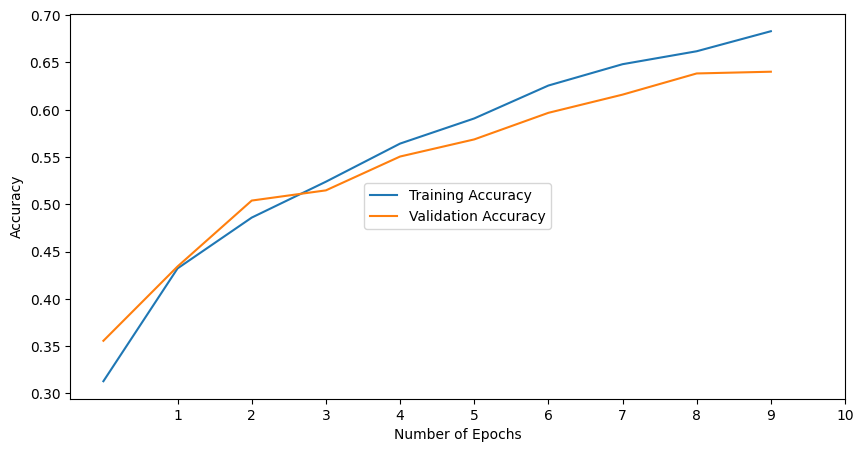

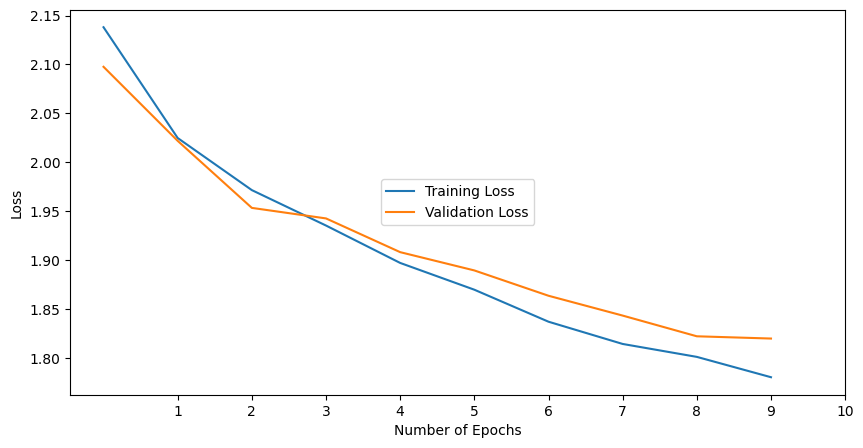

0.6402171415441177 49.80421799999749


In [169]:
padding = 3
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 10
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_kernel3(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy, ex_time)

# Stride

In [170]:
batch_size = 128

In [171]:
# Model creation
num_of_channels = 3

def baseline_stride2(padding=3):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=2, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 128, kernel_size=3, stride=2, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 32, kernel_size=3, stride=2, padding = padding),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 4 * 4 , 10),
        nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [172]:
trial, lo= baseline_stride2()

In [173]:
summary(trial, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 18, 18]          896
├─ReLU: 1-2                              [-1, 32, 18, 18]          --
├─MaxPool2d: 1-3                         [-1, 32, 9, 9]            --
├─Conv2d: 1-4                            [-1, 128, 7, 7]           36,992
├─ReLU: 1-5                              [-1, 128, 7, 7]           --
├─MaxPool2d: 1-6                         [-1, 128, 3, 3]           --
├─Conv2d: 1-7                            [-1, 32, 4, 4]            36,896
├─ReLU: 1-8                              [-1, 32, 4, 4]            --
├─Flatten: 1-9                           [-1, 512]                 --
├─Linear: 1-10                           [-1, 10]                  5,130
├─Softmax: 1-11                          [-1, 10]                  --
Total params: 79,914
Trainable params: 79,914
Non-trainable params: 0
Total mult-adds (M): 2.68
Input size (MB): 0.01
Forward/backward pass siz

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 18, 18]          896
├─ReLU: 1-2                              [-1, 32, 18, 18]          --
├─MaxPool2d: 1-3                         [-1, 32, 9, 9]            --
├─Conv2d: 1-4                            [-1, 128, 7, 7]           36,992
├─ReLU: 1-5                              [-1, 128, 7, 7]           --
├─MaxPool2d: 1-6                         [-1, 128, 3, 3]           --
├─Conv2d: 1-7                            [-1, 32, 4, 4]            36,896
├─ReLU: 1-8                              [-1, 32, 4, 4]            --
├─Flatten: 1-9                           [-1, 512]                 --
├─Linear: 1-10                           [-1, 10]                  5,130
├─Softmax: 1-11                          [-1, 10]                  --
Total params: 79,914
Trainable params: 79,914
Non-trainable params: 0
Total mult-adds (M): 2.68
Input size (MB): 0.01
Forward/backward pass siz

In [174]:
def train_stride2(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_stride2()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 2.2006016803693167 and validation loss: 2.1435073375701905 and training accuracy 0.24463508702531644 and validation accuracy 0.3113970588235294
Epoch 2 trained with training loss: 2.1046050620984427 and validation loss: 2.097948729991913 and training accuracy 0.3513152689873418 and validation accuracy 0.35905330882352937
Epoch 3 trained with training loss: 2.059285429459584 and validation loss: 2.0539828538894653 and training accuracy 0.40036590189873417 and validation accuracy 0.4067267922794118
Epoch 4 trained with training loss: 2.0231369477284105 and validation loss: 2.0248119473457336 and training accuracy 0.4378461234177215 and validation accuracy 0.43327780330882354
Epoch 5 trained with training loss: 1.9962856814831118 and validation loss: 2.0167910933494566 and training accuracy 0.46607990506329117 and validation accuracy 0.4425149356617647
Epoch 6 trained with training loss: 1.9788847543016266 and validation loss: 1.9916152358055115 and tra

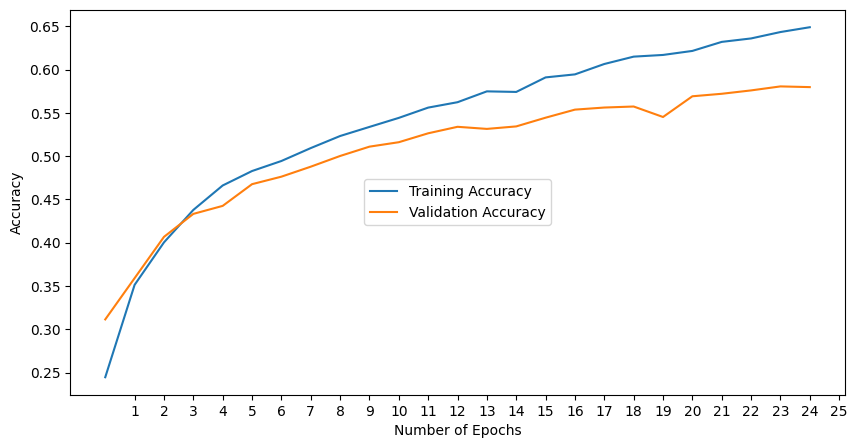

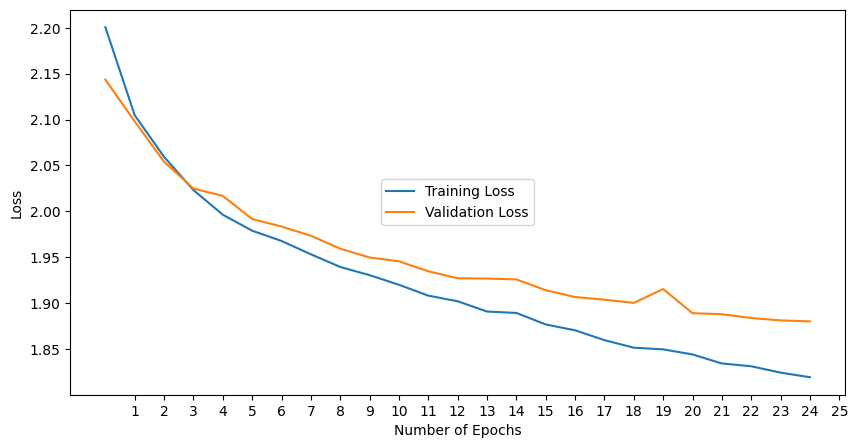

0.5796875 113.42471900000237


In [175]:
padding = 3
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_stride2(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline_S2")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy, ex_time)

### We see overfitting

# Droupout

## Dropout = 0.2

In [ ]:
def baseline_dropout1(padding=3):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 128, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(32 * 15 * 15 , 10)#,
        #nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [ ]:
trial, lo= baseline_dropout1()

In [ ]:
summary(trial, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 36, 36]          896
├─ReLU: 1-2                              [-1, 32, 36, 36]          --
├─MaxPool2d: 1-3                         [-1, 32, 18, 18]          --
├─Conv2d: 1-4                            [-1, 128, 22, 22]         36,992
├─ReLU: 1-5                              [-1, 128, 22, 22]         --
├─MaxPool2d: 1-6                         [-1, 128, 11, 11]         --
├─Conv2d: 1-7                            [-1, 32, 15, 15]          36,896
├─ReLU: 1-8                              [-1, 32, 15, 15]          --
├─Flatten: 1-9                           [-1, 7200]                --
├─Dropout: 1-10                          [-1, 7200]                --
├─Linear: 1-11                           [-1, 10]                  72,010
Total params: 146,794
Trainable params: 146,794
Non-trainable params: 0
Total mult-adds (M): 27.33
Input size (MB): 0.01
Forward/backward pass

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 36, 36]          896
├─ReLU: 1-2                              [-1, 32, 36, 36]          --
├─MaxPool2d: 1-3                         [-1, 32, 18, 18]          --
├─Conv2d: 1-4                            [-1, 128, 22, 22]         36,992
├─ReLU: 1-5                              [-1, 128, 22, 22]         --
├─MaxPool2d: 1-6                         [-1, 128, 11, 11]         --
├─Conv2d: 1-7                            [-1, 32, 15, 15]          36,896
├─ReLU: 1-8                              [-1, 32, 15, 15]          --
├─Flatten: 1-9                           [-1, 7200]                --
├─Dropout: 1-10                          [-1, 7200]                --
├─Linear: 1-11                           [-1, 10]                  72,010
Total params: 146,794
Trainable params: 146,794
Non-trainable params: 0
Total mult-adds (M): 27.33
Input size (MB): 0.01
Forward/backward pass

In [ ]:
def train_dropout1(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_dropout1()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 1.4364891928672792 and validation loss: 2.5106161859469673 and training accuracy 0.48745 and validation accuracy 0.32178514376996803
Epoch 2 trained with training loss: 1.0474613090276719 and validation loss: 2.059828039175405 and training accuracy 0.63425 and validation accuracy 0.3990615015974441
Epoch 3 trained with training loss: 0.8908672605991363 and validation loss: 2.1649242997550355 and training accuracy 0.688475 and validation accuracy 0.43001198083067094
Epoch 4 trained with training loss: 0.7921899613142014 and validation loss: 1.8281656747427992 and training accuracy 0.72565 and validation accuracy 0.48921725239616615
Epoch 5 trained with training loss: 0.7229316699981689 and validation loss: 2.225370824908296 and training accuracy 0.74465 and validation accuracy 0.4364017571884984
Epoch 6 trained with training loss: 0.6593833066701889 and validation loss: 1.9442293259282462 and training accuracy 0.771175 and validation accuracy 0.475439

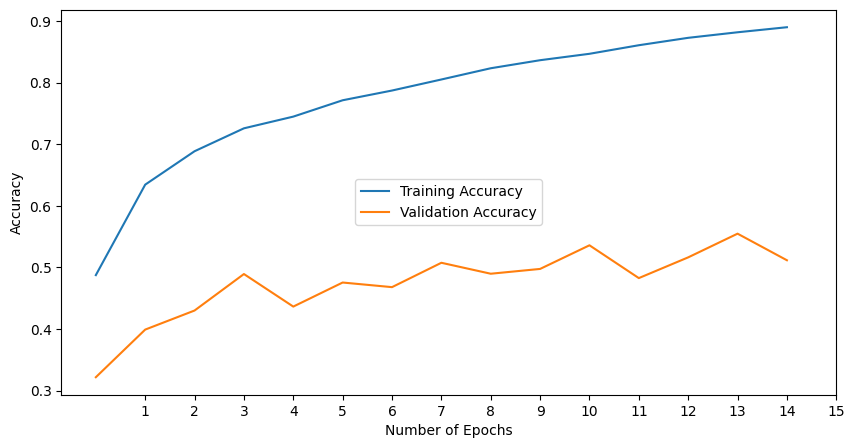

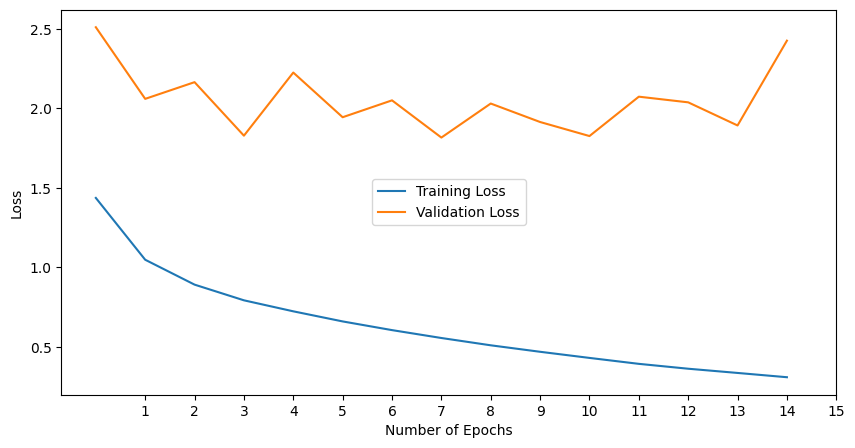

0.5115814696485623 430.72841999999946


In [ ]:
padding = 3
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 15
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_dropout1(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline_D1")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)
print(model_accuracy, ex_time)

## Dropout = 0.8

In [104]:
def baseline_dropout2(padding=3):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.Flatten(),
        nn.Dropout(0.8),
        nn.Linear(32 * 15 * 15 , 10)#,
        #nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [105]:
def train_dropout2(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_dropout2()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 1.4398084767341615 and validation loss: 2.3167707291654884 and training accuracy 0.488225 and validation accuracy 0.26188099041533547
Epoch 2 trained with training loss: 1.0708808266878127 and validation loss: 2.185956229417088 and training accuracy 0.626975 and validation accuracy 0.3502396166134185
Epoch 3 trained with training loss: 0.914463503408432 and validation loss: 2.174132646844029 and training accuracy 0.6826 and validation accuracy 0.35982428115015974
Epoch 4 trained with training loss: 0.8160803781032562 and validation loss: 1.935652629255106 and training accuracy 0.716325 and validation accuracy 0.4010583067092652
Epoch 5 trained with training loss: 0.7371244140148163 and validation loss: 2.123965751629668 and training accuracy 0.7418 and validation accuracy 0.3968650159744409
Epoch 6 trained with training loss: 0.6753065573692322 and validation loss: 1.7527524933647425 and training accuracy 0.7642 and validation accuracy 0.452975239616

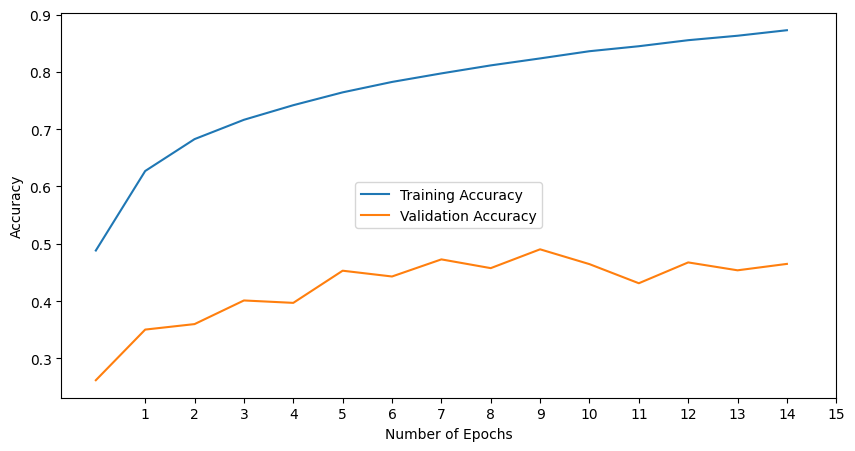

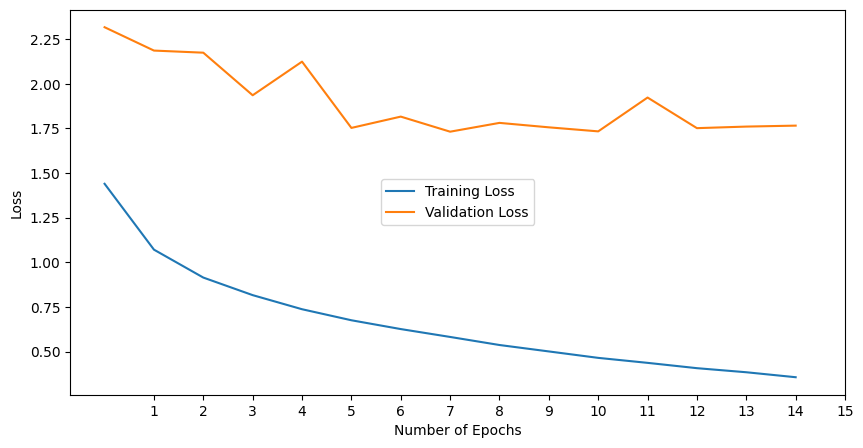

0.46485623003194887 448.22980599999937


In [106]:
padding = 3
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 15
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_dropout2(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline_D2")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy, ex_time)

## Dropout = 0.5

In [107]:
def baseline_dropout3(padding=3):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 128, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(32 * 15 * 15 , 10)# ,
        # nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [108]:
def train_dropout3(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_dropout3()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 1.4401909497261047 and validation loss: 2.8219796948539564 and training accuracy 0.485575 and validation accuracy 0.28184904153354634
Epoch 2 trained with training loss: 1.0402632961273193 and validation loss: 2.47035652265762 and training accuracy 0.6353 and validation accuracy 0.33446485623003197
Epoch 3 trained with training loss: 0.8736790847539901 and validation loss: 2.368475477916364 and training accuracy 0.69335 and validation accuracy 0.33556309904153353
Epoch 4 trained with training loss: 0.7791606047153473 and validation loss: 2.976310961162701 and training accuracy 0.72755 and validation accuracy 0.30141773162939295
Epoch 5 trained with training loss: 0.7015937012076378 and validation loss: 2.3948677271699754 and training accuracy 0.755725 and validation accuracy 0.4309105431309904
Epoch 6 trained with training loss: 0.630485544025898 and validation loss: 2.540918060385 and training accuracy 0.77715 and validation accuracy 0.3854832268370

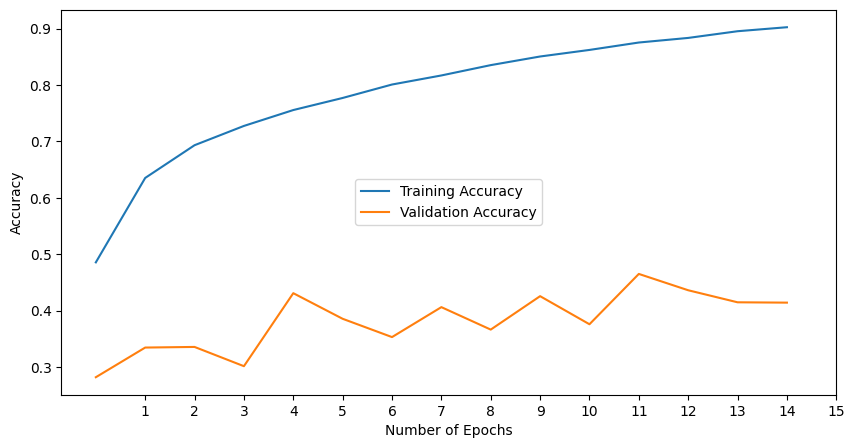

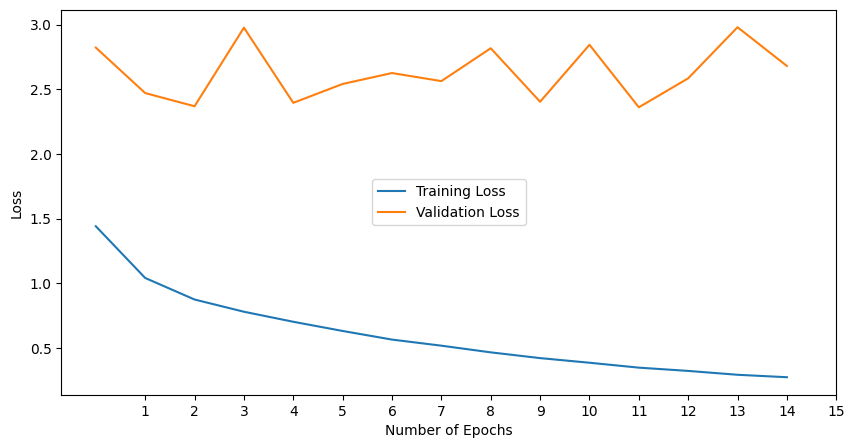

0.41413738019169327 438.53080000000045


In [109]:
padding = 3
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 15
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_dropout3(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline_D3")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy, ex_time)

# Batchnorm

## Batchnorm in 1 layer

In [176]:
def baseline_batchnorm1(padding=3):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding = padding),
        nn.BatchNorm2d(32),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = padding),
        nn.BatchNorm2d(64),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding = padding),
        nn.BatchNorm2d(32),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 15 * 15 , 10)# ,
        # nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [177]:
def train_batchnorm1(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_batchnorm1()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 1.561762169946598 and validation loss: 1.3738102257251739 and training accuracy 0.44996044303797467 and validation accuracy 0.4974264705882353
Epoch 2 trained with training loss: 1.1271480352063723 and validation loss: 1.17088543176651 and training accuracy 0.600721914556962 and validation accuracy 0.5800723805147059
Epoch 3 trained with training loss: 0.9552457121354115 and validation loss: 1.099483358860016 and training accuracy 0.6657189477848101 and validation accuracy 0.6082950367647059
Epoch 4 trained with training loss: 0.8553795316551305 and validation loss: 1.0439074277877807 and training accuracy 0.7035700158227848 and validation accuracy 0.6427734375
Epoch 5 trained with training loss: 0.7819076527523089 and validation loss: 0.8998814523220062 and training accuracy 0.7263399920886076 and validation accuracy 0.6901654411764706
Epoch 6 trained with training loss: 0.7436440602133546 and validation loss: 0.9042985528707504 and training accurac

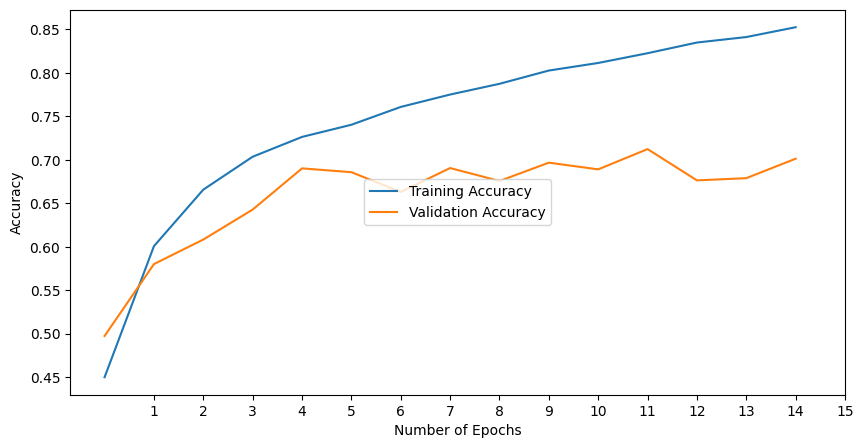

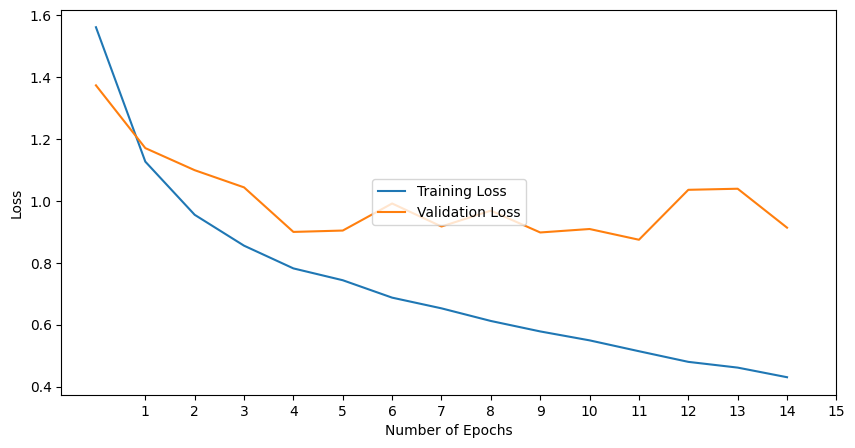

0.7012867647058824 91.67116100000567


In [178]:
padding = 3
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 15
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_batchnorm1(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline_B1")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)
print(model_accuracy, ex_time)

## Batchnorm in two layers

In [189]:
def baseline_batchnorm2(padding=3):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding = padding),
        nn.BatchNorm2d(32),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = padding),
        nn.BatchNorm2d(64),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding = padding),
        # nn.Dropout(0.5),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 15 * 15 , 10),
        nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [190]:
def train_batchnorm2(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_batchnorm2()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 2.0532921658286565 and validation loss: 1.9974119007587432 and training accuracy 0.40325850474683544 and validation accuracy 0.46174172794117646
Epoch 2 trained with training loss: 1.9454983684081066 and validation loss: 1.9528623402118683 and training accuracy 0.5157980617088608 and validation accuracy 0.5078239889705882
Epoch 3 trained with training loss: 1.8939947780174544 and validation loss: 1.898309975862503 and training accuracy 0.5679143591772152 and validation accuracy 0.5611615349264706
Epoch 4 trained with training loss: 1.8644661797752864 and validation loss: 1.903621143102646 and training accuracy 0.5974831882911392 and validation accuracy 0.5563246783088236
Epoch 5 trained with training loss: 1.8336488174486765 and validation loss: 1.8520477414131165 and training accuracy 0.6309088212025317 and validation accuracy 0.6097254136029412


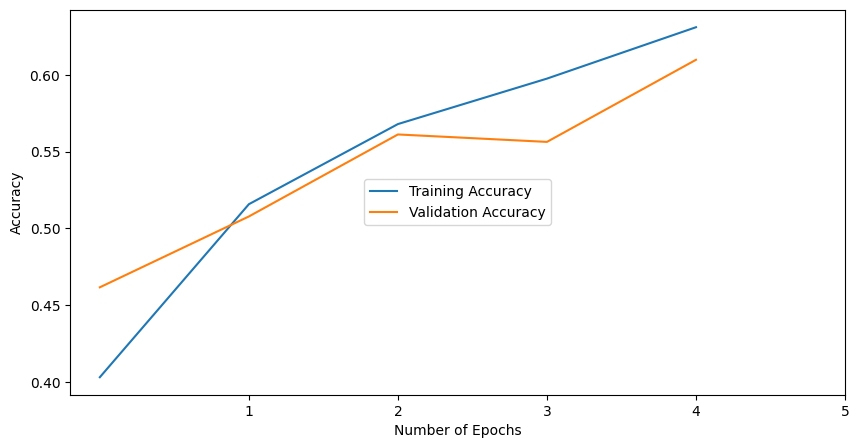

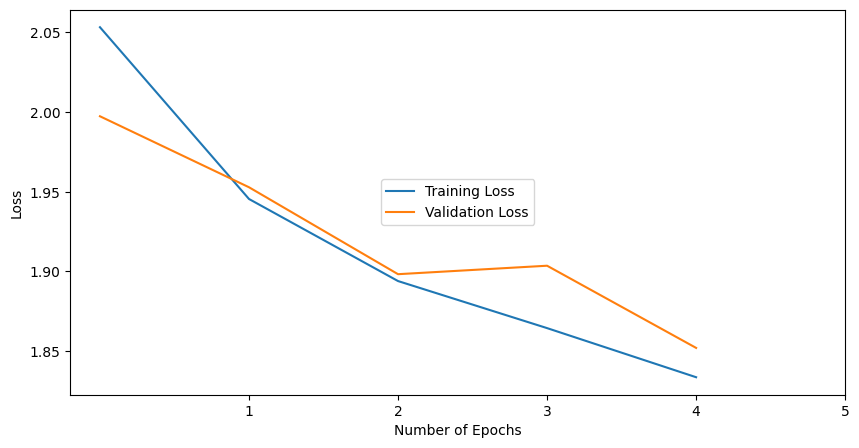

0.6097254136029412 31.6083540000036


In [191]:
padding = 3
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 5
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_batchnorm2(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline_B2")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy, ex_time)

## Batchnorm with three layers

In [192]:
def baseline_batchnorm3(padding=3):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding = padding),
        nn.BatchNorm2d(32),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = padding),
        nn.BatchNorm2d(64),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding = padding),
        nn.BatchNorm2d(32),
        # nn.Dropout(0.5),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 15 * 15 , 10)# ,
        #nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [193]:
def train_batchnorm3(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_batchnorm3()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 1.5087512263768836 and validation loss: 1.3223905622959138 and training accuracy 0.4634098101265823 and validation accuracy 0.5307846966911764
Epoch 2 trained with training loss: 1.0754400167284133 and validation loss: 1.117507815361023 and training accuracy 0.6225029667721519 and validation accuracy 0.6160788143382353
Epoch 3 trained with training loss: 0.9300739199300355 and validation loss: 1.029974916577339 and training accuracy 0.6754351265822784 and validation accuracy 0.6393382352941177
Epoch 4 trained with training loss: 0.8403918878941596 and validation loss: 0.9530832707881928 and training accuracy 0.7097755142405063 and validation accuracy 0.6674747242647059
Epoch 5 trained with training loss: 0.7670413172697719 and validation loss: 0.950643903017044 and training accuracy 0.7337074762658228 and validation accuracy 0.6709214154411764
Epoch 6 trained with training loss: 0.7037732088113133 and validation loss: 0.897777646780014 and training a

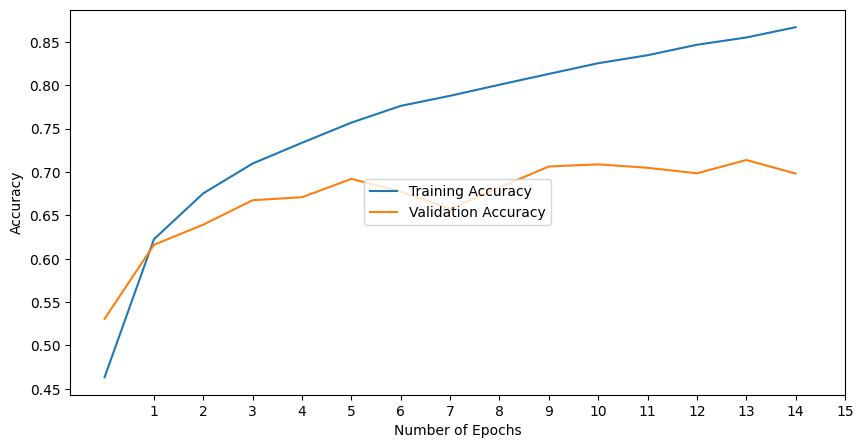

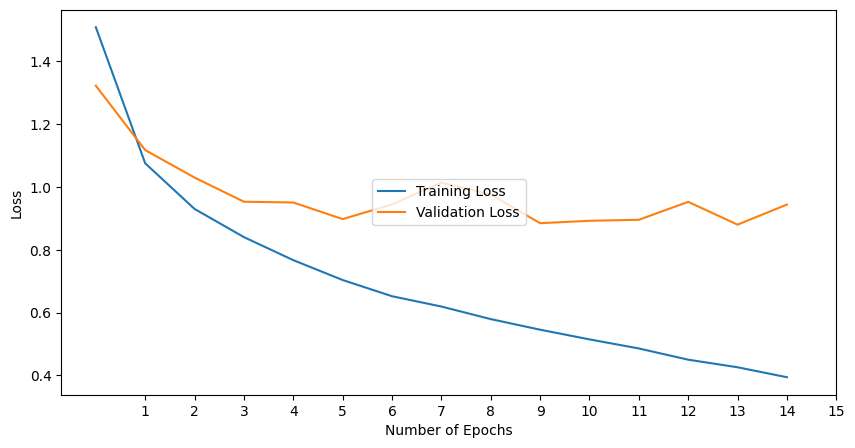

0.6982019761029412 91.03990399999748


In [194]:
padding = 3
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 15
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_batchnorm3(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline_B3")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy, ex_time)

# Adding layers

In [195]:
def baseline_addlayers1(padding=3):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = padding),
        actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        # nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        # actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 17 * 17 , 10),
        nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [196]:
def train_addlayers1(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_addlayers1()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 2.1688632029521315 and validation loss: 2.1220213890075685 and training accuracy 0.2807060917721519 and validation accuracy 0.33214613970588236
Epoch 2 trained with training loss: 2.079041233545617 and validation loss: 2.076919746398926 and training accuracy 0.37645866297468356 and validation accuracy 0.37887178308823527
Epoch 3 trained with training loss: 2.045439994787868 and validation loss: 2.054551351070404 and training accuracy 0.41213409810126583 and validation accuracy 0.4003848805147059
Epoch 4 trained with training loss: 2.0120017226738267 and validation loss: 2.0068045258522034 and training accuracy 0.44568334651898733 and validation accuracy 0.45155675551470587
Epoch 5 trained with training loss: 1.9969236247147186 and validation loss: 2.0115613520145414 and training accuracy 0.45967662183544306 and validation accuracy 0.4458122702205882
Epoch 6 trained with training loss: 1.9780203360545485 and validation loss: 1.9756725311279297 and tra

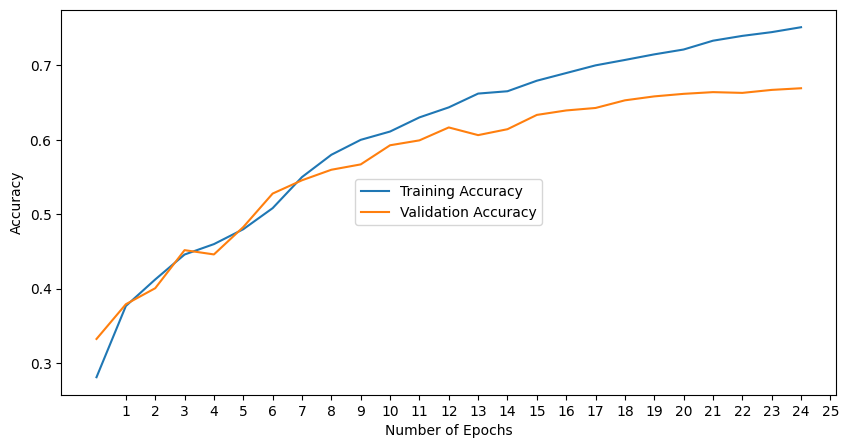

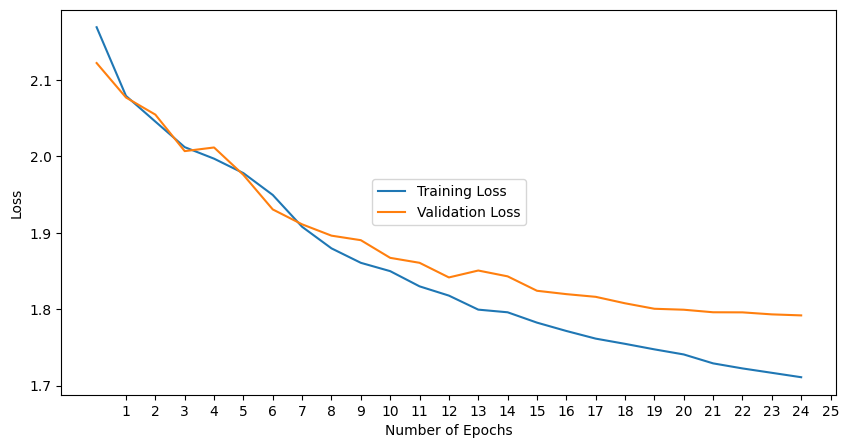

0.6692612591911764 137.5058530000024


In [197]:
padding = 3
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_addlayers1(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline_L1")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy, ex_time)

## ----

In [198]:
def baseline_addlayers2(padding=3):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = padding),
        actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(32 * 10 * 10 , 10),
        nn.Softmax(1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [199]:
def train_addlayers2(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_addlayers2()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 2.1679793309561814 and validation loss: 2.1150402188301087 and training accuracy 0.2789507515822785 and validation accuracy 0.3383099724264706
Epoch 2 trained with training loss: 2.0774288268028935 and validation loss: 2.0638959884643553 and training accuracy 0.3786095727848101 and validation accuracy 0.39194048713235297
Epoch 3 trained with training loss: 2.044747372216816 and validation loss: 2.033279740810394 and training accuracy 0.41171380537974683 and validation accuracy 0.4239200367647059
Epoch 4 trained with training loss: 2.0166251161430457 and validation loss: 2.0178097605705263 and training accuracy 0.43965090981012656 and validation accuracy 0.4386661305147059
Epoch 5 trained with training loss: 1.9925427497187747 and validation loss: 1.9870272994041442 and training accuracy 0.46469541139240506 and validation accuracy 0.4695255055147059
Epoch 6 trained with training loss: 1.9678822272940526 and validation loss: 1.978751003742218 and train

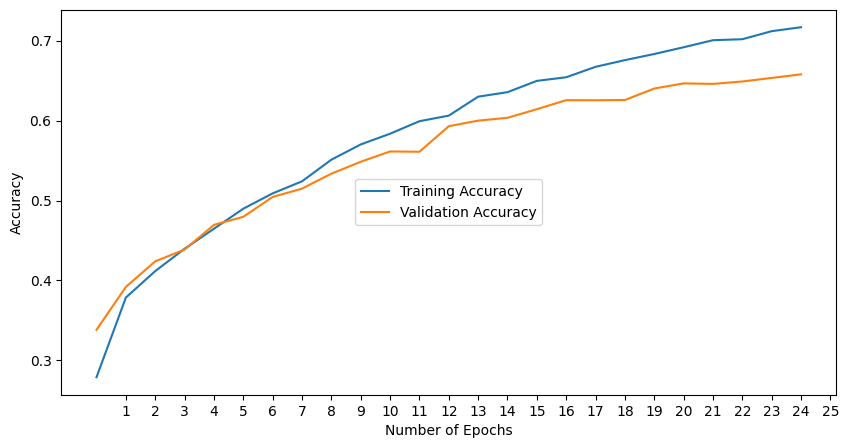

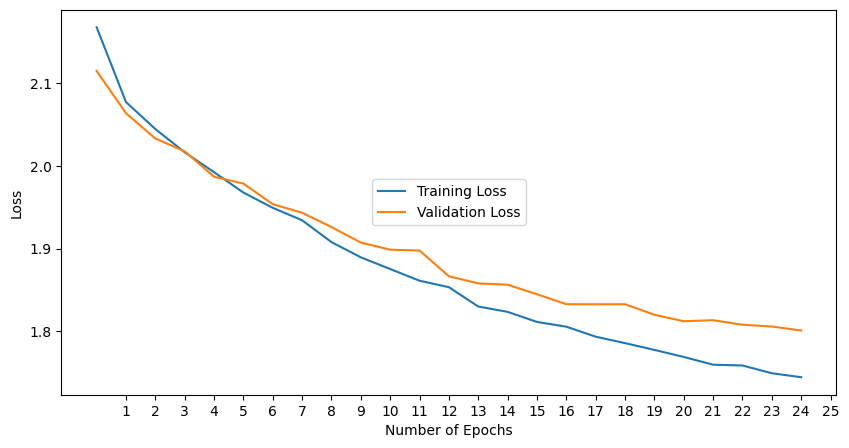

0.6579159007352942 152.45554200000333


In [188]:
padding = 3
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_addlayers2(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline_L2")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy, ex_time)

# ---

In [35]:
def baseline_addlayers3(padding=3):
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding = padding),
        actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding = padding),
        actfn,
        # nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding = padding),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(32 * 10 * 10 , 512),
        actfn,
        nn.Linear(512, 10)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss()

    return baseline_model, classification_loss

In [30]:
trial, lo= baseline_addlayers3()

In [31]:
summary(trial, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 36, 36]          896
├─ReLU: 1-2                              [-1, 32, 36, 36]          --
├─MaxPool2d: 1-3                         [-1, 32, 18, 18]          --
├─Conv2d: 1-4                            [-1, 64, 22, 22]          18,496
├─ReLU: 1-5                              [-1, 64, 22, 22]          --
├─Conv2d: 1-6                            [-1, 128, 26, 26]         73,856
├─ReLU: 1-7                              [-1, 128, 26, 26]         --
├─MaxPool2d: 1-8                         [-1, 128, 13, 13]         --
├─Conv2d: 1-9                            [-1, 64, 17, 17]          73,792
├─ReLU: 1-10                             [-1, 64, 17, 17]          --
├─Conv2d: 1-11                           [-1, 32, 21, 21]          18,464
├─ReLU: 1-12                             [-1, 32, 21, 21]          --
├─MaxPool2d: 1-13                        [-1, 32, 10, 10]          -

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 36, 36]          896
├─ReLU: 1-2                              [-1, 32, 36, 36]          --
├─MaxPool2d: 1-3                         [-1, 32, 18, 18]          --
├─Conv2d: 1-4                            [-1, 64, 22, 22]          18,496
├─ReLU: 1-5                              [-1, 64, 22, 22]          --
├─Conv2d: 1-6                            [-1, 128, 26, 26]         73,856
├─ReLU: 1-7                              [-1, 128, 26, 26]         --
├─MaxPool2d: 1-8                         [-1, 128, 13, 13]         --
├─Conv2d: 1-9                            [-1, 64, 17, 17]          73,792
├─ReLU: 1-10                             [-1, 64, 17, 17]          --
├─Conv2d: 1-11                           [-1, 32, 21, 21]          18,464
├─ReLU: 1-12                             [-1, 32, 21, 21]          --
├─MaxPool2d: 1-13                        [-1, 32, 10, 10]          -

In [36]:
def train_addlayers3(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_addlayers3()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

Epoch 1 trained with training loss: 1.6430985998153687 and validation loss: 1.3593940171189964 and training accuracy 0.3918 and validation accuracy 0.509185303514377
Epoch 2 trained with training loss: 1.2379487629890442 and validation loss: 1.1048163781150842 and training accuracy 0.5515 and validation accuracy 0.601138178913738
Epoch 3 trained with training loss: 1.05162327337265 and validation loss: 1.019515593402302 and training accuracy 0.625075 and validation accuracy 0.6321884984025559
Epoch 4 trained with training loss: 0.923403442788124 and validation loss: 0.913340614817013 and training accuracy 0.671375 and validation accuracy 0.6784145367412141
Epoch 5 trained with training loss: 0.8367300023794174 and validation loss: 0.9111560033723569 and training accuracy 0.703625 and validation accuracy 0.6779153354632588
Epoch 6 trained with training loss: 0.7604110926032066 and validation loss: 0.8536186233496132 and training accuracy 0.7292 and validation accuracy 0.6960862619808307

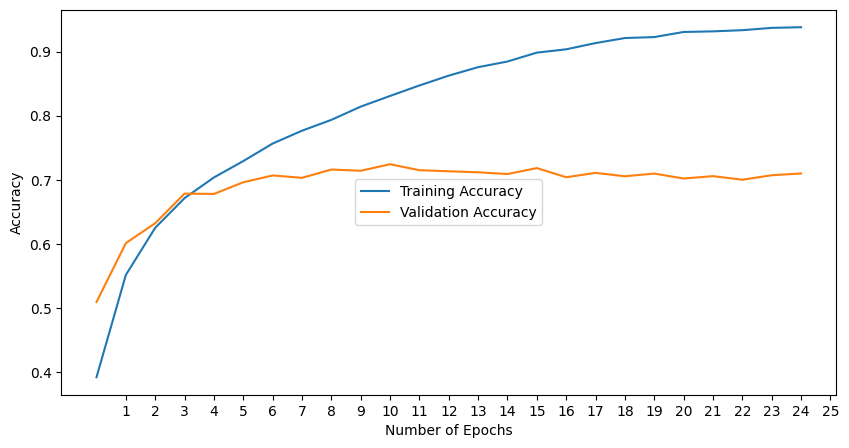

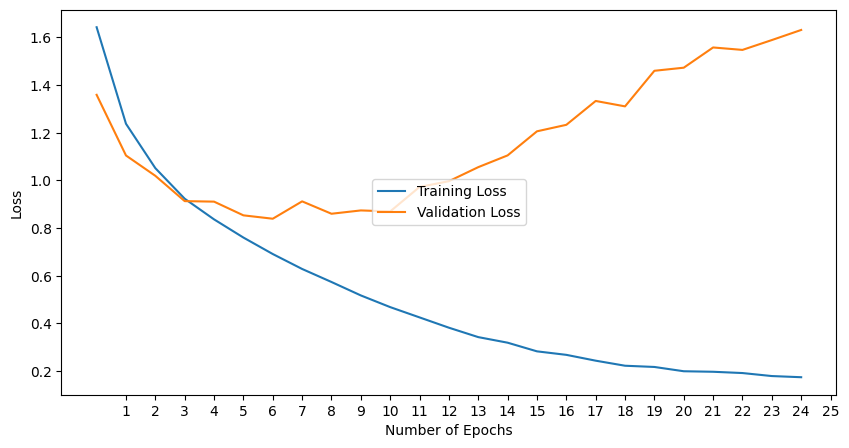

0.7098642172523961 1055.4576650000001


In [37]:
padding = 3
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_addlayers3(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline_L3")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy, ex_time)

## New model

In [200]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transforms.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         transforms.ToTensor(), 
                         transforms.Normalize(*stats,inplace=True)])
valid_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])


In [201]:
train_ds = CIFAR10(root='data/', download=True, transform=train_tfms)
valid_ds = CIFAR10(root='data/', train=False, transform=valid_tfms)

Files already downloaded and verified


In [202]:
dataset_size = len(train_ds)
test_dataset_size = len(valid_ds)
print(train_ds)
print(valid_ds)


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


In [203]:
batch_size = 32

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [204]:
# Model creation
num_of_channels = 3

def baseline_new_model():
    baseline_model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            # nn.Softmax(1)
        ).to(device)

    classification_loss = nn.CrossEntropyLoss()
    
    return baseline_model, classification_loss
    


In [205]:
trial, lo= baseline_new_model()

In [206]:
trial, lo = baseline_new_model()

In [207]:
summary(trial, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          896
├─ReLU: 1-2                              [-1, 32, 32, 32]          --
├─Conv2d: 1-3                            [-1, 64, 32, 32]          18,496
├─ReLU: 1-4                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-5                         [-1, 64, 16, 16]          --
├─Conv2d: 1-6                            [-1, 128, 16, 16]         73,856
├─ReLU: 1-7                              [-1, 128, 16, 16]         --
├─Conv2d: 1-8                            [-1, 128, 16, 16]         147,584
├─ReLU: 1-9                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-10                        [-1, 128, 8, 8]           --
├─Conv2d: 1-11                           [-1, 256, 8, 8]           295,168
├─ReLU: 1-12                             [-1, 256, 8, 8]           --
├─Conv2d: 1-13                           [-1, 256, 8, 8]          

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          896
├─ReLU: 1-2                              [-1, 32, 32, 32]          --
├─Conv2d: 1-3                            [-1, 64, 32, 32]          18,496
├─ReLU: 1-4                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-5                         [-1, 64, 16, 16]          --
├─Conv2d: 1-6                            [-1, 128, 16, 16]         73,856
├─ReLU: 1-7                              [-1, 128, 16, 16]         --
├─Conv2d: 1-8                            [-1, 128, 16, 16]         147,584
├─ReLU: 1-9                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-10                        [-1, 128, 8, 8]           --
├─Conv2d: 1-11                           [-1, 256, 8, 8]           295,168
├─ReLU: 1-12                             [-1, 256, 8, 8]           --
├─Conv2d: 1-13                           [-1, 256, 8, 8]          

In [208]:
def train_new_model(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_new_model()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer



Epoch 1 trained with training loss: 2.3027528207513352 and validation loss: 2.3025906085968018 and training accuracy 0.09926325158227849 and validation accuracy 0.09650160845588235
Epoch 2 trained with training loss: 2.3026328509366967 and validation loss: 2.30253084897995 and training accuracy 0.09953520569620253 and validation accuracy 0.1005859375
Epoch 3 trained with training loss: 2.3026070775865 and validation loss: 2.302495503425598 and training accuracy 0.0990654667721519 and validation accuracy 0.11877297794117647
Epoch 4 trained with training loss: 2.302565076683141 and validation loss: 2.3024484753608703 and training accuracy 0.10067246835443038 and validation accuracy 0.09989659926470588
Epoch 5 trained with training loss: 2.302497577063645 and validation loss: 2.3023921251296997 and training accuracy 0.09879351265822785 and validation accuracy 0.09964958639705881
Epoch 6 trained with training loss: 2.302417797378347 and validation loss: 2.3022751808166504 and training accu

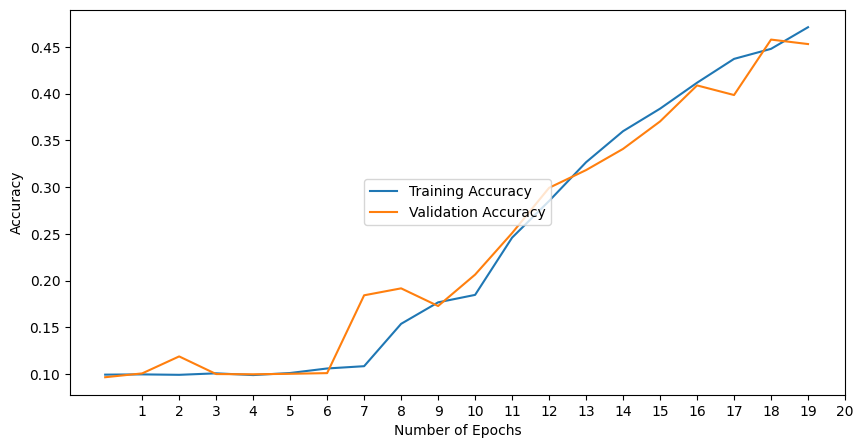

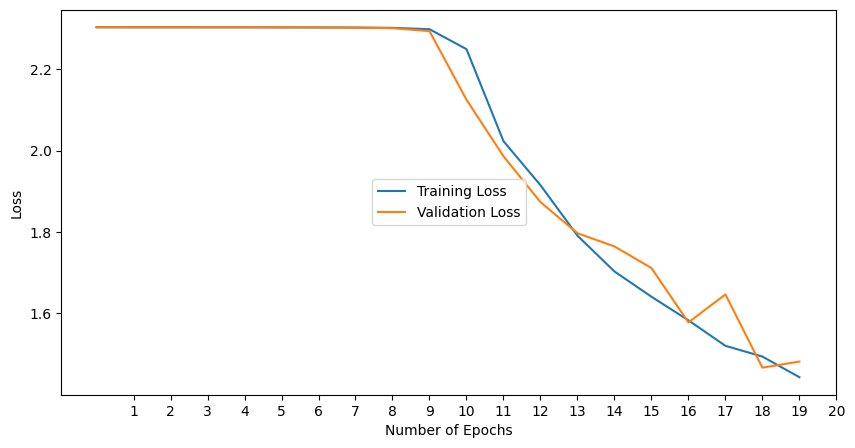

0.453125


In [210]:
padding = 1
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 20
lr = 0.01
momentum = 0.9

model_accuracy, ex_time = train_new_model(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline_V2")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy)

Epoch 1 trained with training loss: 1.8841090323049812 and validation loss: 1.6131602466106414 and training accuracy 0.2859226661392405 and validation accuracy 0.3743853400735294
Epoch 2 trained with training loss: 1.4292984446392785 and validation loss: 1.4045400440692901 and training accuracy 0.47008504746835444 and validation accuracy 0.47483340992647055
Epoch 3 trained with training loss: 1.1854090615163875 and validation loss: 1.0953361451625825 and training accuracy 0.5665793117088608 and validation accuracy 0.5983972886029412
Epoch 4 trained with training loss: 0.9978106580203092 and validation loss: 1.0326194435358047 and training accuracy 0.6408722310126582 and validation accuracy 0.6261374080882354
Epoch 5 trained with training loss: 0.8517660181733626 and validation loss: 0.8939610451459885 and training accuracy 0.6966228243670886 and validation accuracy 0.6823069852941177
Epoch 6 trained with training loss: 0.7317092275317711 and validation loss: 0.9111605405807495 and trai

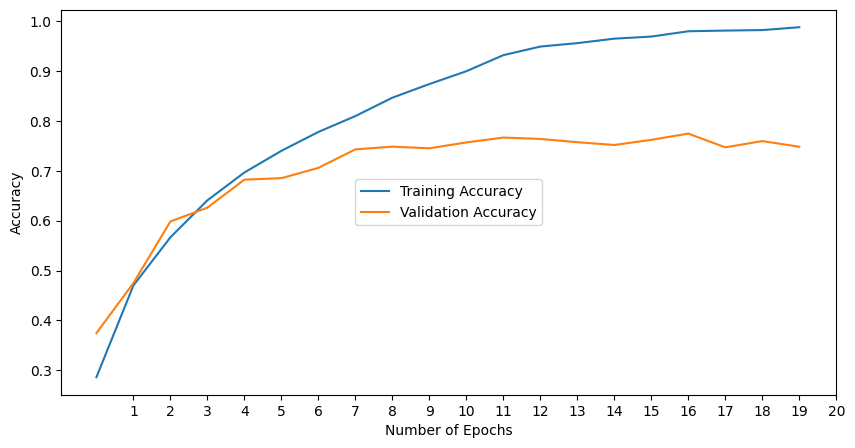

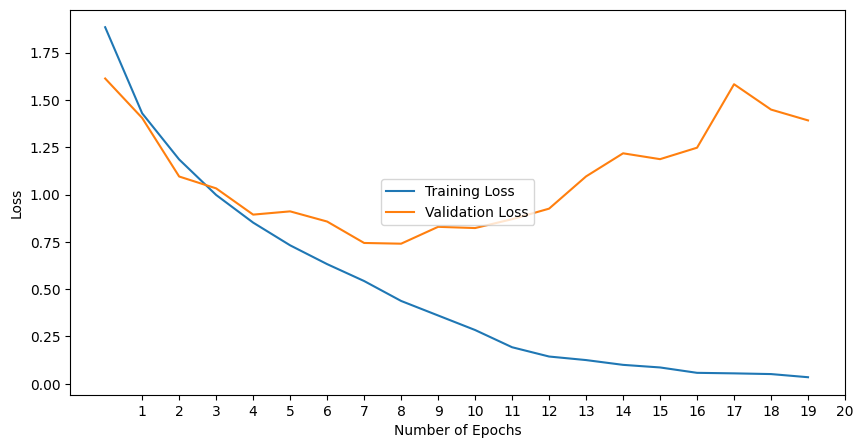

0.7482996323529412


In [211]:
padding = 1
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 20
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_new_model(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("Baseline_V2")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy)

# New Model 2

In [212]:
device = torch.device("cpu")

In [213]:
# Model creation
num_of_channels = 3

def baseline_new_model2():
    baseline_model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Dropout(0.2),
            nn.Linear(256*4*4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 10)).to(torch.device("cpu"))

    classification_loss = nn.CrossEntropyLoss()
    
    return baseline_model, classification_loss
    


In [214]:
trial, lo= baseline_new_model2()

In [215]:
summary(trial, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          896
├─BatchNorm2d: 1-2                       [-1, 32, 32, 32]          64
├─ReLU: 1-3                              [-1, 32, 32, 32]          --
├─Conv2d: 1-4                            [-1, 64, 32, 32]          18,496
├─BatchNorm2d: 1-5                       [-1, 64, 32, 32]          128
├─ReLU: 1-6                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-7                         [-1, 64, 16, 16]          --
├─Conv2d: 1-8                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-9                       [-1, 128, 16, 16]         256
├─ReLU: 1-10                             [-1, 128, 16, 16]         --
├─Conv2d: 1-11                           [-1, 128, 16, 16]         147,584
├─BatchNorm2d: 1-12                      [-1, 128, 16, 16]         256
├─ReLU: 1-13                             [-1, 128, 16, 16]         -

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          896
├─BatchNorm2d: 1-2                       [-1, 32, 32, 32]          64
├─ReLU: 1-3                              [-1, 32, 32, 32]          --
├─Conv2d: 1-4                            [-1, 64, 32, 32]          18,496
├─BatchNorm2d: 1-5                       [-1, 64, 32, 32]          128
├─ReLU: 1-6                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-7                         [-1, 64, 16, 16]          --
├─Conv2d: 1-8                            [-1, 128, 16, 16]         73,856
├─BatchNorm2d: 1-9                       [-1, 128, 16, 16]         256
├─ReLU: 1-10                             [-1, 128, 16, 16]         --
├─Conv2d: 1-11                           [-1, 128, 16, 16]         147,584
├─BatchNorm2d: 1-12                      [-1, 128, 16, 16]         256
├─ReLU: 1-13                             [-1, 128, 16, 16]         -

In [217]:
import os
os.environ['WANDB_CONSOLE'] = 'off'


In [218]:
def train_new_model2(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_new_model2()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model.to(torch.device("cpu"))

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer



Epoch 1 trained with training loss: 1.2409380093405518 and validation loss: 1.1828244626522064 and training accuracy 0.549520371835443 and validation accuracy 0.5801987591911765
Epoch 2 trained with training loss: 0.7851649998109552 and validation loss: 0.917028272151947 and training accuracy 0.7224337420886076 and validation accuracy 0.6833524816176471
Epoch 3 trained with training loss: 0.589671072326129 and validation loss: 0.7547264933586121 and training accuracy 0.7937598892405063 and validation accuracy 0.7436810661764706
Epoch 4 trained with training loss: 0.4658551042592978 and validation loss: 0.7224592328071594 and training accuracy 0.837050039556962 and validation accuracy 0.7611155790441176
Epoch 5 trained with training loss: 0.3656427230261549 and validation loss: 0.6613657474517822 and training accuracy 0.8713409810126582 and validation accuracy 0.7837660845588236
Epoch 6 trained with training loss: 0.28289712041239196 and validation loss: 0.6671695798635483 and training 

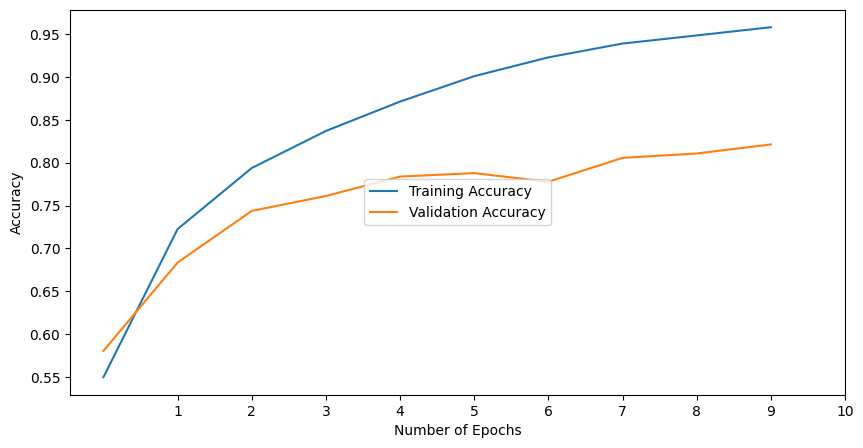

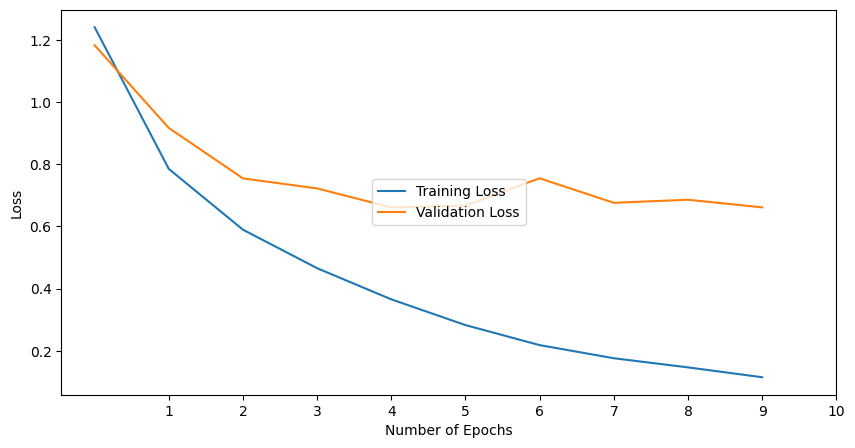

0.8213177849264707


In [219]:
padding = 1
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 10
lr = 0.001
momentum = 0

model_accuracy, ex_time = train_new_model2(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("New Model")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy)

Epoch 1 trained with training loss: 1.2828364643096923 and validation loss: 0.9723291769385719 and training accuracy 0.547525 and validation accuracy 0.6575479233226837
Epoch 2 trained with training loss: 0.8130485252380371 and validation loss: 0.7863642083951079 and training accuracy 0.717175 and validation accuracy 0.7283346645367412
Epoch 3 trained with training loss: 0.622954975438118 and validation loss: 0.6384815926940296 and training accuracy 0.784925 and validation accuracy 0.7865415335463258
Epoch 4 trained with training loss: 0.5099066031098366 and validation loss: 0.5932404617912853 and training accuracy 0.823075 and validation accuracy 0.7969249201277955
Epoch 5 trained with training loss: 0.4106348387420177 and validation loss: 0.5741386364062373 and training accuracy 0.85585 and validation accuracy 0.808805910543131
Epoch 6 trained with training loss: 0.3268195599257946 and validation loss: 0.5688379896096528 and training accuracy 0.88565 and validation accuracy 0.8125
Ep

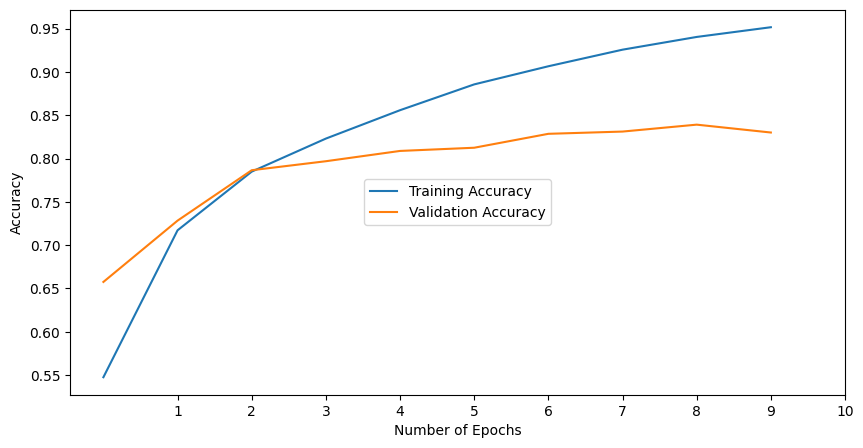

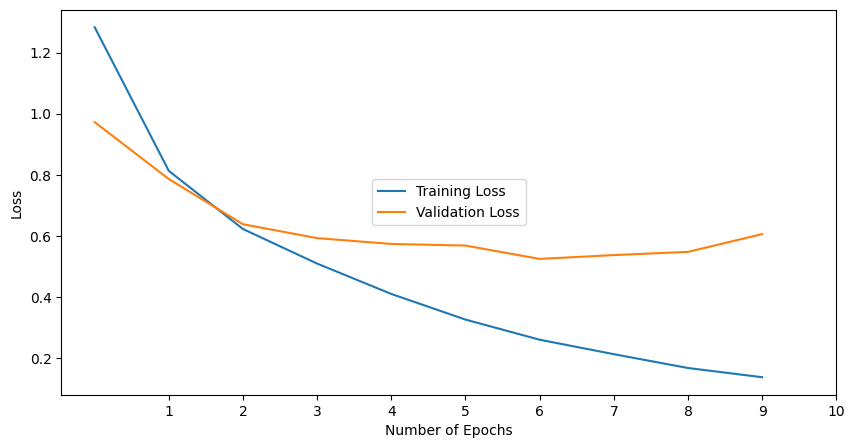

0.8300718849840255


In [73]:
padding = 1
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 10
lr = 0.01
momentum = 0.9

model_accuracy, ex_time = train_new_model2(trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum)

accuracy_dict["Model"].append("New Model")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy)

In [220]:
def evaluate(model, classification_loss, val_loader):
    model.eval()
    
    val_loss = 0
    val_acc = 0
    
    with torch.no_grad():

        for val_inputs, val_labels in val_loader:

            val_inputs, val_labels = val_inputs.to(device),val_labels.to(device)

            val_outputs = model(val_inputs)
        
            loss = classification_loss(val_outputs, val_labels)

            val_loss += loss.item()

            val_acc += accuracy(val_outputs, val_labels)

    val_acc = val_acc/len(val_loader)


    val_loss = val_loss/len(val_loader)

    return val_loss, val_acc

    # outputs = [model.validation_step(batch) for batch in val_loader]
    # return model.validation_epoch_end(outputs)

In [221]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [222]:
def validation_step(batch):
        
        images, labels = batch 
        out = model(images.to(device))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(device))   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

In [223]:
def train_new_model2(train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum):

    actfn = activation_func(act_val)
    model, classification_loss = baseline_new_model2()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer



In [224]:
def train_new_model3(epochs, max_lr, model, classification_loss, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    # torch.cuda.empty_cache()
    stats = []

    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

    model.to(device)

    for epoch in range(epochs):
        # Training Phase 
        result = {}
        model.train()
        train_losses = 0
        lrs = []
        for batch in train_loader:
            inputs, labels = batch

            # zero the parameter gradients
            # optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.to(device))

            loss = classification_loss(outputs, labels.to(device))
            # loss = model.training_step(batch)
            train_losses += loss
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result['val_loss'], result['val_acc'] = evaluate(model, classification_loss, val_loader)
        result['train_loss'] = train_losses/len(train_loader)
        result['lrs'] = lrs
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        # model.epoch_end(epoch, result)
        stats.append(result)
    return stats

In [225]:
model, classification_loss = baseline_new_model2()

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
os.environ['WANDB_CONSOLE'] = 'off'

model_stats = train_new_model3(epochs, max_lr, model, classification_loss, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 1.3504, val_loss: 1.3173, val_acc: 0.5476
Epoch [1], train_loss: 1.1102, val_loss: 1.0041, val_acc: 0.6543
Epoch [2], train_loss: 1.0784, val_loss: 0.9860, val_acc: 0.6600
Epoch [3], train_loss: 0.9855, val_loss: 0.9274, val_acc: 0.6783
Epoch [4], train_loss: 0.8668, val_loss: 0.8711, val_acc: 0.6973
Epoch [5], train_loss: 0.7238, val_loss: 0.5889, val_acc: 0.8011
Epoch [6], train_loss: 0.5859, val_loss: 0.4457, val_acc: 0.8531
Epoch [7], train_loss: 0.4875, val_loss: 0.4159, val_acc: 0.8619


In [227]:
def plot_accuracies(model_stats):
    accuracies = [x['val_acc'] for x in model_stats]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

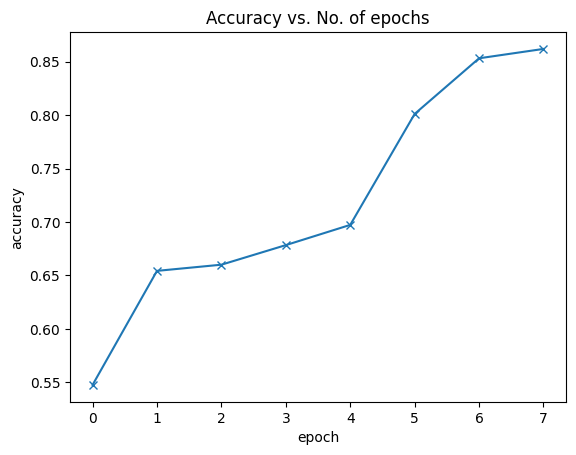

In [228]:
plot_accuracies(model_stats)

# LR Finder

In [229]:
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers import FastaiLRFinder, ProgressBar

In [230]:
device = device = torch.device("cpu") # "cuda" if torch.cuda.is_available() else "cpu"
#criterion = nn.CrossEntropyLoss() #nn.NLLLoss()
model, criterion = baseline_new_model2()
#model = Net()
# model.to(device)  # Move model before creating optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4) #optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)

In [231]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
ProgressBar(persist=True).attach(trainer, output_transform=lambda x: {"batch loss": x})

lr_finder = FastaiLRFinder()
to_save={'model': model, 'optimizer': optimizer}
with lr_finder.attach(trainer, to_save, diverge_th=1.5) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_dl)
    
trainer.run(train_dl, max_epochs=10)

evaluator = create_supervised_evaluator(model, metrics={"acc": Accuracy(), "loss": Loss(nn.CrossEntropyLoss())}, device=device)
evaluator.run(valid_dl)

print(evaluator.state.metrics)

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

{'acc': 0.876, 'loss': 0.353333203125}


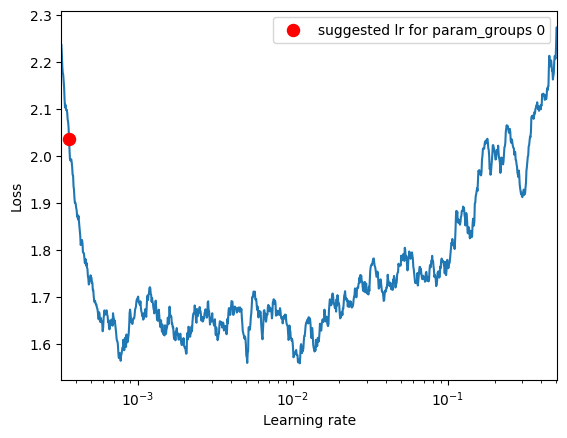

<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>

In [232]:
lr_finder.plot()

In [233]:
lr_finder.lr_suggestion()

0.00036153080994917684

In [234]:
optimizer.param_groups[0]['lr'] = lr_finder.lr_suggestion()

trainer.run(train_dl, max_epochs=10)
evaluator.run(valid_dl)
print(evaluator.state.metrics)


[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

[1/1563]   0%|           [00:00<?]

{'acc': 0.8987, 'loss': 0.3102023193359375}


# GoogleNet

In [235]:
from torchvision import models
from torchvision.models import GoogLeNet_Weights
googlenet = models.googlenet(pretrained=True, progress=True).to(torch.device("mps"))

/Users/macbook/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/macbook/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [236]:
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
classification_loss = nn.CrossEntropyLoss()

In [237]:
train_ds = CIFAR10(root='data/', download=True, transform=GoogLeNet_Weights.DEFAULT.transforms())

train_indices, val_indices = train_test_split(list(range(len(train_ds.targets))), test_size = 0.2, stratify = train_ds.targets)

train_data = torch.utils.data.Subset(train_ds, train_indices)
val_data = torch.utils.data.Subset(train_ds, val_indices)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=True)

# valid_ds = CIFAR10(root='data/', train=False, transform=valid_tfms)

test_ds = CIFAR10(root='./data', train=False,
                                       download=True, transform=GoogLeNet_Weights.DEFAULT.transforms())
testloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [238]:
googlenet.fc = nn.Linear(1024, 10)
googlenet.to(torch.device("mps"))

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [242]:
def train_googlenet(model, train_loader, val_loader, act_val, optimizer_val, num_epochs, lr, momentum, device_type):

    actfn = activation_func(act_val)
    # model = googlenet.copy()
    classification_loss = nn.CrossEntropyLoss()
    # model, classification_loss = baseline_new_model2()
    optimizer = optimizer_func(model, optimizer_val, lr, momentum)
    device = torch.device(device_type)

    model_stats = []
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    start_time = time.process_time()

    for epoch in range(num_epochs):

        train_acc, train_loss = train_model(model, classification_loss, train_loader, optimizer)

        val_acc, val_loss = validate_model(model, classification_loss, val_loader, optimizer)

        print(f"Epoch {epoch+1} trained with training loss: {train_loss} and validation loss: {val_loss} and training accuracy {train_acc} and validation accuracy {val_acc}")

        stats = {"Epoch": epoch, "Train_loss": train_loss, "Validation_loss": val_loss, "Train_acc": train_acc, "Val_acc": val_acc}

        model_stats.append(stats)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

    end_time = time.process_time()

    timer = end_time - start_time

    plt.figure(figsize=[10,5])

    
    plt.plot(train_acc_list,label="Training Accuracy")
    
    plt.plot(val_acc_list, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    plt.figure(figsize=[10,5])
    plt.plot(train_loss_list, linestyle='-',label="Training Loss")
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel("Number of Epochs")
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,num_epochs+1,1))
#     plt.yticks(np.arange(5,60,5))
    plt.legend(loc='center')
    plt.show()

    return val_acc_list[-1], timer

In [240]:
device = torch.device("mps")

In [243]:
padding = 0
act_val = "ReLU"
optimizer_val = "SGD"
num_epochs = 25
lr = 0.001
momentum = 0.9
device_type = "mps"

model_accuracy, ex_time = train_googlenet(googlenet, trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum, device_type)

accuracy_dict["Model"].append("Google Net")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy, ex_time)

In [ ]:
padding = 0
act_val = "ReLU"
optimizer_val = "Adam"
num_epochs = 25
lr = 0.001
momentum = 0.9
device_type = "mps"

model_accuracy, ex_time = train_googlenet(googlenet, trainloader, valloader, act_val, optimizer_val, num_epochs, lr, momentum, device_type)

accuracy_dict["Model"].append("Google Net")
accuracy_dict["Batch Size"].append(batch_size)
accuracy_dict["Padding"].append(padding)
accuracy_dict["Optimizer"].append(optimizer_val)
accuracy_dict["Number of epochs"].append(num_epochs)
accuracy_dict["Learning Rate"].append(lr)
accuracy_dict["Momentum"].append(momentum)
accuracy_dict["Run Time"].append(ex_time)
accuracy_dict["Validation Accuracy"].append(model_accuracy*100)

print(model_accuracy, ex_time)